# LLM Text Summarization Evaluation
## Status: Experimental

## Evaluation process as coded in this notebook

1. **Summarization Evaluation**:

     Use Examinee models to produce summaries for the CNN-Daily Mail Dataset. This dataset can be replaced with your own dataset and groundtruth
   
     Calculate ROUGE Scores and Cosine Similarity scores for the summaries

     Perform a Qualitative assessment of the summaries using Claude-as-a-Judge

     Display Evaluation Results


2. **Multiple Choice Question-Answering (QA) Evaluation**:

     Claude, in an Examiner role, reads customer document and creates question bank and a choice of correct and incorrect answers for each question
     
     Administer Multiple Choice QA test to the LLMs operating in Examinee role and score their responses
     

3. **Reading Comprehension Style Question-Answering Evaluation**

   Chunk and store user provided document in FAISS Vector store
   
   Claude, in Examiner role, creates Question Bank and corresponding answers (Ground Truth)
   
   Each question is answered by each of the Examinee models by fetching the corresponding chunks of reference document from vector store
   
   Evaluate each of the Examinee answer responses by performing a Cosine Similarity with the Ground Truth
   
   Claude, in Examiner role, is employed to evaluate the answer responses
   
   Display Results and Leaderboard

## How to use this notebook

### Configuration Parameters

Customize your experiments by adjusting these important parameters:


1. **Make sure you've requested and were granted access to Bedrock Models via:
       https://console.aws.amazon.com/bedrock/home?region=<region_name>/modelaccess
 

2. **Enable AWS IAM permissions for SageMaker's execution role include access to Bedrock**

3. **Input File for QA Tests**:
   - Define the location of the input file for your QA tests. The default location is the present working directory (pwd), and the default log file name is "notebook_log.log."


4. **Number of Documents to Summarize**:
   - Modify the `num_to_eval` global variable to specify the number of documents you wish to summarize. The default is set to 20.


5. **Number of QA Questions to Generate**:
   - Adjust the `num_questions` global variable to determine the quantity of questions to generate. The default is set to 5, and it should be an even number.

6. **Endpoint Throttling Timers**:
   - Configure the following timers to prevent endpoint throttling issues for specific model endpoints:
       - `titan_sleep_timer = 0`
       - `jurassic_sleep_timer = 5`
       - `claude_sleep_timer = 5`
       - `oneshot_sleep_timer = 5`

   - Fine-tune these timers if you encounter endpoint throttling problems with a particular model's endpoint.
7. **Execute Notebook**

In [1]:
#
# Undo the following comments if this notebook is being intantiated and run for the first time in your environment
#
# Install required packages
!pip install boto3==1.28.57 --quiet
!pip install botocore --quiet
!pip install langchain==0.0.190 --quiet
!pip install ipywidgets --upgrade --quiet
!pip install datasets --quiet
!pip install rouge-score --quiet
!pip install pypdf --quiet
!pip install faiss-cpu --quiet
!pip install plotly --quiet
!pip install pypdf --quiet
!pip install IPython

In [36]:
import os
import logging
import boto3
import json
import time
import re
import numpy as np
from numpy.linalg import norm
from rouge_score import rouge_scorer
from datasets import load_dataset
from ipywidgets import IntProgress
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import faiss
import random
import mimetypes
import pypdf  # Replace 'pypdf' with 'PyPDF2'
import sys
import seaborn as sns
import concurrent.futures
from sklearn.preprocessing import normalize
import nltk
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
)

In [37]:
# Set up the logger
logging.basicConfig(
    filename="notebook_log.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s: %(message)s",
)

In [38]:
bedrock = boto3.client("bedrock-runtime")

### Tuneable Prompts:
1. **Summary_Titan_Jurassic_Prompt_Base** - Prompt used to instruct Titan or Jurassic to Summarize a document
2. **Claude_Summary_Prompt_Base** - Prompt used to instruct Claude to Summarize a document
4. **Claude_Eval_Summary_Prompt_Base** - Prompt used to instruct Claude to evaluate the Summary provided using Claude as a judge

In [39]:
# Titan & Jurassic Use this Prompt for Summarizing Documents
Summary_Titan_Jurassic_Prompt_Base = """Summarize the following text from a news article and please ensure that you generate a summary that's at least 3 sentences in length.

<Begin Text>
[DISCUSSION]
<End Text>
"""

# Claude has a special prompt format and we use that for summarization
Claude_Summary_Prompt_Base = """Human: Summarize the following text from a news article and please ensure that you generate a summary that's at least 3 sentences in length. Please do not include your prologue "Here is a ..." in the summary.

<Begin Text>
[DISCUSSION]
<End Text>

Assistant:

"""

Claude_Eval_Summary_Prompt_Base = """

Human: You will be given a summmary of a news article. Your task is to evaluate the summary in four dimensions, accuracy, coherence, factuality, and completeness. Provide a score of 1-5 in each dimension, with 5 being the best score.

Original discussion: [DISCUSSION]

Summary: [SUMMARY]

Evaluation form (scores only):

- Coherence: 
- Accuracy:
- Factuality:
- Completeness:


Assistant:
"""

In [40]:
# Define a function to invoke the Bedrock model
def invoke_model(body, model_id, accept, prompt, content_type):
    """
    Invoke a machine learning model using Bedrock.

    Args:
        body (str): The request body containing the input data.
        model_id (str): The ID of the machine learning model to invoke.
        accept (str): The accept header specifying the response format.
        prompt (str): The prompt or input for the model.
        content_type (str): The content type of the request.

    Returns:
        dict: The response from the model as a JSON dictionary.
    """
    logging.info(
        f"Invoking model with prompt: {prompt}"
    )  # Log the prompt being sent to the model

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())
    return response_body

In [41]:
#
# Remove the prologue that Claude adds to the summary. The prologue goes variously as "Here is the summmary:" or "Here is the summary in three sentences:"
#


def remove_summary_prologue(text):
    """
    Remove the prologue that Claude adds to the summary.
    The prologue goes variously as "Here is the summary:" or "Here is the summary in three sentences:"
    """
    pattern = r"Here is a summary[^.]*\:"
    modified_text = re.sub(pattern, "", text, count=1)

    return modified_text


# Function to invoke Titan model
def InvokeTitan(titan_jurassic_prompt_eng_base, docs_to_summarize, num_to_eval):
    """
    Invoke the Titan model for summarization.

    Args:
        titan_jurassic_prompt_eng_base (str): Base prompt for Titan.
        docs_to_summarize (list or str): List of documents or a single document for summarization.
        num_to_eval (int): Number of evaluations.

    Returns:
        list: List of Titan summaries.
    """
    logging.info("Invoking Titan...")

    modelId = "amazon.titan-tg1-large"
    accept = "application/json"
    contentType = "application/json"
    titan_sums = []

    if num_to_eval > 1:
        count = 0
        max_count = num_to_eval
        f = IntProgress(min=0, max=max_count)
        display(f)

        for doc in docs_to_summarize:
            f.value += 1
            count += 1
            tjprompt = titan_jurassic_prompt_eng_base.replace("[DISCUSSION]", doc)
            body = json.dumps({"inputText": tjprompt})
            titan_response = invoke_model(
                body, "amazon.titan-tg1-large", accept, tjprompt, contentType
            )
            titan_sums.append(titan_response["results"][0]["outputText"])
            time.sleep(titan_sleep_timer)
    else:
        doc = docs_to_summarize
        tjprompt = titan_jurassic_prompt_eng_base.replace("[DISCUSSION]", doc)
        body = json.dumps({"inputText": tjprompt})
        titan_response = invoke_model(
            body, "amazon.titan-tg1-large", accept, tjprompt, contentType
        )
        titan_sums.append(titan_response["results"][0]["outputText"])

    return titan_sums


# Function to invoke Jurassic model
def InvokeJurassic(titan_jurassic_prompt_eng_base, docs_to_summarize, num_to_eval):
    """
    Invoke the Jurassic model for summarization.

    Args:
        titan_jurassic_prompt_eng_base (str): Base prompt for Jurassic.
        docs_to_summarize (list or str): List of documents or a single document for summarization.
        num_to_eval (int): Number of evaluations.

    Returns:
        list: List of Jurassic summaries.
    """
    logging.info("Invoking Jurassic...")

    modelId = "ai21.j2-mid"
    accept = "application/json"
    contentType = "application/json"
    jurassic_sums = []

    if num_to_eval > 1:
        count = 0
        max_count = num_to_eval
        f = IntProgress(min=0, max=max_count)
        display(f)

        for doc in docs_to_summarize:
            f.value += 1
            count += 1
            tjprompt = titan_jurassic_prompt_eng_base.replace("[DISCUSSION]", doc)
            body = json.dumps(
                {
                    "prompt": tjprompt,
                    "maxTokens": 212,
                    "temperature": 0.0,
                    "topP": 1,
                    "stopSequences": [],
                    "countPenalty": {"scale": 0},
                    "presencePenalty": {"scale": 0},
                    "frequencyPenalty": {"scale": 0},
                }
            )

            jurassic_response = invoke_model(
                body, "ai21.j2-mid", accept, tjprompt, contentType
            )

            jurassic_sums.append(jurassic_response["completions"][0]["data"]["text"])
            time.sleep(jurassic_sleep_timer)

    else:
        doc = docs_to_summarize
        tjprompt = titan_jurassic_prompt_eng_base.replace("[DISCUSSION]", doc)
        body = json.dumps({"prompt": tjprompt})
        time.sleep(oneshot_sleep_timer)

        jurassic_response = invoke_model(
            body, "ai21.j2-mid", accept, tjprompt, contentType
        )

        jurassic_sums.append(jurassic_response["completions"][0]["data"]["text"])

    return jurassic_sums


# Function to invoke Claude model
def InvokeClaude(claude_summary_eng_base, docs_to_summarize, num_to_eval):
    """
    Invoke the Claude model for summarization.

    Args:
        claude_summary_eng_base (str): Base prompt for Claude.
        docs_to_summarize (list or str): List of documents or a single document for summarization.
        num_to_eval (int): Number of evaluations.

    Returns:
        list: List of Claude summaries.
    """
    logging.info("Invoking Claude...")

    modelId = "anthropic.claude-v1"
    accept = "application/json"
    contentType = "application/json"
    claude_sums = []

    if num_to_eval > 1:
        count = 0
        max_count = num_to_eval
        f = IntProgress(min=0, max=max_count)
        display(f)

        for doc in docs_to_summarize:
            f.value += 1
            count += 1
            sprompt = claude_summary_eng_base.replace("[DISCUSSION]", doc)
            body = json.dumps(
                {"prompt": sprompt, "temperature": 0.0, "max_tokens_to_sample": 400}
            )

            response = bedrock.invoke_model(
                body=body, modelId=modelId, accept=accept, contentType=contentType
            )

            response_body = json.loads(response.get("body").read())
            modified_claude_sum = remove_summary_prologue(response_body["completion"])
            claude_sums.append(modified_claude_sum)
            time.sleep(claude_sleep_timer)

    else:
        doc = docs_to_summarize
        sprompt = claude_summary_eng_base.replace("[DISCUSSION]", doc)
        body = json.dumps(
            {"prompt": sprompt, "temperature": 0.0, "max_tokens_to_sample": 400}
        )

        time.sleep(oneshot_sleep_timer)
        response = bedrock.invoke_model(
            body=body, modelId=modelId, accept=accept, contentType=contentType
        )

        response_body = json.loads(response.get("body").read())
        modified_claude_sum = remove_summary_prologue(response_body["completion"])
        claude_sums.append(modified_claude_sum)

    return claude_sums

In [42]:
def get_embedding(body, modelId, accept, contentType):
    """
    Get embedding from a machine learning model using Bedrock.

    Args:
        body (str): The request body containing the input data.
        modelId (str): The ID of the machine learning model to invoke.
        accept (str): The accept header specifying the response format.
        contentType (str): The content type of the request.

    Returns:
        dict: The embedding obtained from the model response.
    """
    logging.info(f"Getting embedding from model: {modelId}")  # Log the model being used

    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())
    embedding = response_body.get("embedding")
    return embedding


def get_array_of_embeddings(summaries):
    """
    Get an array of embeddings from a list of summaries.

    Args:
        summaries (list): List of summary texts.

    Returns:
        list: List of embeddings obtained from the models.
    """
    modelId = "amazon.titan-e1t-medium"
    accept = "application/json"
    contentType = "application/json"

    array_embeddings = []
    for summary in summaries:
        doc = {"inputText": summary}
        body = json.dumps(doc)
        embedding = get_embedding(body, modelId, accept, contentType)
        array_embeddings.append(embedding)
        time.sleep(oneshot_sleep_timer)

    return array_embeddings

In [43]:
import concurrent.futures

# List of models and their names
models = ["Titan", "Jurassic", "Claude"]


def wrap_df_text(df):
    return display(
        HTML(
            df.to_html(justify="left")
            .replace("\\n", "")
            .replace("<td>", '<td style="text-align:left">')
        )
    )


# Function to evaluate model summaries
def create_summaries(models, docs_to_summarize, docs_gt, num_to_eval):
    """
    Create summaries using multiple models concurrently and display them in a DataFrame.

    Args:
        models (list): List of model names.
        docs_to_summarize (list): List of documents to be summarized.
        num_to_eval (int): Number of evaluations.

    Returns:
        tuple: A tuple containing the summaries from Titan, Jurassic, and Claude models.
    """

    logging.info(f"Summarizing these documents: {docs_to_summarize}")

    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        for i in range(len(models)):
            if models[i] == "Titan":
                print("Titan summarizing documents ...")
                future_titan = executor.submit(
                    InvokeTitan,
                    Summary_Titan_Jurassic_Prompt_Base,
                    docs_to_summarize,
                    num_to_eval,
                )

                # logging.info(f"Summary by {models[i]} is : {tsums}")
            elif models[i] == "Jurassic":
                print("Jurassic summarizing documents ...")
                future_jurassic = executor.submit(
                    InvokeJurassic,
                    Summary_Titan_Jurassic_Prompt_Base,
                    docs_to_summarize,
                    num_to_eval,
                )

                # logging.info(f"Summary by {models[i]} is : {jsums}")

            elif models[i] == "Claude":
                print("Claude summarizing documents ...")
                future_claude = executor.submit(
                    InvokeClaude,
                    Claude_Summary_Prompt_Base,
                    docs_to_summarize,
                    num_to_eval,
                )

                # logging.info(f"Summary by {models[i]} is : {csums}")

        concurrent.futures.wait([future_titan, future_jurassic, future_claude])

        tsums = future_titan.result()
        jsums = future_jurassic.result()
        csums = future_claude.result()

    df = pd.DataFrame([csums, jsums, tsums, docs_gt]).transpose()
    df.columns = ["Claude", "Jurassic", "Titan", "Ground Truth"]

    wrap_df_text(df)

    return tsums, jsums, csums

In [44]:
def display_summary_evals(
    titan_gt_cosine_sim, jurassic_gt_cosine_sim, claude_gt_cosine_sim, srows, scols
):
    """
    Display summary evaluations using bar plots and interactive heatmaps.

    Args:
        titan_gt_cosine_sim (list): List of Titan-Ground Truth cosine similarity scores.
        jurassic_gt_cosine_sim (list): List of Jurassic-Ground Truth cosine similarity scores.
        claude_gt_cosine_sim (list): List of Claude-Ground Truth cosine similarity scores.
    """
    result_docs = []
    result_models = []
    result_types = []
    result_values = []

    for r in result_map:
        for m in ["claude", "titan", "jurassic", "gt"]:
            for t in ["accuracy", "coherence", "factuality", "completeness"]:
                result_docs.append(r["doc"])
                result_values.append(r[m][t])
                result_types.append(t)
                result_models.append(m)

    import pandas as pd

    df = pd.DataFrame(
        {
            "doc": result_docs,
            "value": result_values,
            "type": result_types,
            "model": result_models,
        }
    )
    df["value"] = df["value"].astype(int)

    sns.set(rc={"figure.figsize": (16, 8)})
    sns.barplot(data=df, x="type", y="value", hue="model")
    plt.title("Summaries Judged by Claude")
    plt.show()

    import plotly.graph_objects as go

    # Reshape the data into a 2D array (e.g., 4x5 grid)
    heatmap_data_jurassic = np.array(jurassic_gt_cosine_sim).reshape(srows, scols)
    heatmap_data_titan = np.array(titan_gt_cosine_sim).reshape(srows, scols)
    heatmap_data_claude = np.array(claude_gt_cosine_sim).reshape(srows, scols)

    # Create the heatmap figure using plotly
    heatmap_fig_jurassic = go.Figure(
        data=go.Heatmap(z=heatmap_data_jurassic, colorscale="temps_r", zmin=0, zmax=1)
    )

    heatmap_fig_titan = go.Figure(
        data=go.Heatmap(z=heatmap_data_titan, colorscale="temps_r", zmin=0, zmax=1)
    )

    heatmap_fig_claude = go.Figure(
        data=go.Heatmap(z=heatmap_data_claude, colorscale="temps_r", zmin=0, zmax=1)
    )

    # Customize the layout of the figure (optional)
    heatmap_fig_jurassic.update_layout(
        title="Interactive Heatmap of Cosine Similarities for Summaries Produced by Jurassic vs Ground Truth",
        xaxis=dict(title="X-axis"),
        yaxis=dict(title="Y-axis"),
    )

    heatmap_fig_titan.update_layout(
        title="Interactive Heatmap of Cosine Similarities for Summaries Produced by Titan vs Ground Truth",
        xaxis=dict(title="X-axis"),
        yaxis=dict(title="Y-axis"),
    )

    heatmap_fig_claude.update_layout(
        title="Interactive Heatmap of Cosine Similarities for Summaries Produced by Claude vs Ground Truth",
        xaxis=dict(title="X-axis"),
        yaxis=dict(title="Y-axis"),
    )

    # Show the interactive heatmap
    heatmap_fig_titan.show()
    heatmap_fig_jurassic.show()
    heatmap_fig_claude.show()

    return

In [45]:
import re


def parse_sum_result(r):
    """
    Parse summary evaluation results from a given text.

    Args:
        r (str): Text containing evaluation results.

    Returns:
        tuple: A tuple containing accuracy, coherence, factuality, and completeness scores.
    """
    m = re.search("Accuracy: (\d)", r)
    if m is None:
        accuracy = 0
    else:
        accuracy = m.group(1)

    m = re.search("Coherence: (\d)", r)
    if m is None:
        coherence = 0
    else:
        coherence = m.group(1)

    m = re.search("Factuality: (\d)", r)
    if m is None:
        factuality = 0
    else:
        factuality = m.group(1)

    m = re.search("Completeness: (\d)", r)
    if m is None:
        completeness = 0
    else:
        completeness = m.group(1)

    return accuracy, coherence, factuality, completeness

In [46]:
import re


def parse_qa_result(result):
    matches = re.findall("\[([^\]]+)\]?", result)
    if len(matches) == 1:
        return matches[0]
    else:
        return None

In [47]:
import numpy

result_map = []


def evaluate_rouge_scores(models, tsums, jsums, csums, docs_gt, num_to_eval):
    """
    Evaluate ROUGE scores for model summaries and log the results.

    Args:
        models (list): List of model names.
        tsums (list): Titan model summaries.
        jsums (list): Jurassic model summaries.
        csums (list): Claude model summaries.
        docs_gt (list): Ground truth documents.
        num_to_eval (int): Number of evaluations.

    Returns:
        dict: A dictionary containing evaluation results.
    """
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    eval_results = {"Model": [], "ROUGE-1 F1": [], "ROUGE-2 F1": [], "ROUGE-L F1": []}

    summaries = []
    for i in range(len(models)):
        if models[i] == "Titan":
            summaries = tsums
        else:
            if models[i] == "Jurassic":
                summaries = jsums
            else:
                if models[i] == "Claude":
                    summaries = csums

        # Calculate ROUGE scores for each summary
        rouge_1_scores = []
        rouge_2_scores = []
        rouge_l_scores = []

        for j in range(num_to_eval):
            scores = scorer.score(docs_gt[j], summaries[j])
            rouge_1_scores.append(scores["rouge1"].fmeasure)
            rouge_2_scores.append(scores["rouge2"].fmeasure)
            rouge_l_scores.append(scores["rougeL"].fmeasure)

        # Calculate average ROUGE scores
        avg_rouge_1 = sum(rouge_1_scores) / num_to_eval
        avg_rouge_2 = sum(rouge_2_scores) / num_to_eval
        avg_rouge_l = sum(rouge_l_scores) / num_to_eval

        eval_results["Model"].append(models[i])
        eval_results["ROUGE-1 F1"].append(avg_rouge_1)
        eval_results["ROUGE-2 F1"].append(avg_rouge_2)
        eval_results["ROUGE-L F1"].append(avg_rouge_l)

        logging.info(f"Evaluated {models[i]}:")
        logging.info(f"Average ROUGE-1 F1 Score: {avg_rouge_1}")
        logging.info(f"Average ROUGE-2 F1 Score: {avg_rouge_2}")
        logging.info(f"Average ROUGE-L F1 Score: {avg_rouge_l}")

    # Create a dataframe from evaluation results
    eval_df = pd.DataFrame(eval_results)

    # Plot evaluation results
    fig = go.Figure()

    for i in range(len(models)):
        model_name = models[i]
        avg_rouge_1 = eval_df[eval_df["Model"] == model_name]["ROUGE-1 F1"].values[0]
        avg_rouge_2 = eval_df[eval_df["Model"] == model_name]["ROUGE-2 F1"].values[0]
        avg_rouge_l = eval_df[eval_df["Model"] == model_name]["ROUGE-L F1"].values[0]

        fig.add_trace(go.Bar(x=[model_name], y=[avg_rouge_1], name="ROUGE-1"))
        fig.add_trace(go.Bar(x=[model_name], y=[avg_rouge_2], name="ROUGE-2"))
        fig.add_trace(go.Bar(x=[model_name], y=[avg_rouge_l], name="ROUGE-L"))

    fig.update_layout(
        barmode="group", title="Average ROUGE Scores for Summaries Produced by Model"
    )
    fig.show()
    return


def evaluate_cosine_similarity(
    jurassic_gt_cosine_sim,
    titan_gt_cosine_sim,
    claude_gt_cosine_sim,
    num_to_eval,
    tsums,
    jsums,
    csums,
    docs_gt,
):
    """
    Evaluate cosine similarity between model summaries and ground truth documents.

    Args:
        jurassic_gt_cosine_sim (numpy.ndarray): Array to store Jurassic cosine similarity scores.
        titan_gt_cosine_sim (numpy.ndarray): Array to store Titan cosine similarity scores.
        claude_gt_cosine_sim (numpy.ndarray): Array to store Claude cosine similarity scores.
        num_to_eval (int): Number of evaluations.

    Returns:
        None
    """

    titan_embeddings = get_array_of_embeddings(tsums)
    jurassic_embeddings = get_array_of_embeddings(jsums)
    claude_embeddings = get_array_of_embeddings(csums)
    gt_embeddings = get_array_of_embeddings(docs_gt)

    print("Calculating Cosine Similarities for summarization task ...")
    max_count = num_to_eval
    f = IntProgress(min=0, max=max_count)  # instantiate the bar
    display(f)  # display the bar

    for index in range(num_to_eval):
        jurassic_gt_cosine_sim[index] = numpy.dot(
            gt_embeddings[index], jurassic_embeddings[index]
        ) / (norm(gt_embeddings[index]) * norm(jurassic_embeddings[index]))

        titan_gt_cosine_sim[index] = numpy.dot(
            gt_embeddings[index], titan_embeddings[index]
        ) / (norm(gt_embeddings[index]) * norm(titan_embeddings[index]))

        claude_gt_cosine_sim[index] = numpy.dot(
            gt_embeddings[index], claude_embeddings[index]
        ) / (norm(gt_embeddings[index]) * norm(claude_embeddings[index]))
        f.value += 1  # signal to increment the progress bar

    logging.info(
        f"Cosine Similarity Score for Titan Summaries are: {titan_gt_cosine_sim}"
    )
    logging.info(
        f"Cosine Similarity Score for Jurassic Summaries are: {jurassic_gt_cosine_sim}"
    )
    logging.info(
        f"Cosine Similarity Score for Claude Summaries are: {claude_gt_cosine_sim}"
    )

    ig, axs = plt.subplots(1, 3)
    # plt.subplots_adjust(wspace=0.1)

    plt.subplot(1, 3, 1)
    plt.hist(claude_gt_cosine_sim, color="green")
    plt.legend(["claude cosine similarities"])
    plt.xlabel("cosine similarity")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    plt.hist(jurassic_gt_cosine_sim, color="blue")
    plt.legend(["jurassic cosine similarities"])
    plt.xlabel("cosine similarity")
    plt.ylabel("Frequency")
    # plt.show()

    plt.subplot(1, 3, 3)
    plt.hist(titan_gt_cosine_sim, color="orange")
    plt.legend(["titan cosine similarities"])
    plt.xlabel("cosine similarity")
    plt.ylabel("Frequency")
    plt.show()
    return


def claude_as_judge_summmary_eval(docs_to_summarize, csums, tsums, jsums, docs_gt):
    """
    Evaluate summaries using Claude as a judge and log the results.

    Args:
        docs_to_summarize (list): List of documents to summarize.
        csums (list): Claude model summaries.
        tsums (list): Titan model summaries.
        jsums (list): Jurassic model summaries.
        docs_gt (list): Ground truth documents.

    Returns:
        None
    """

    print("Claude-as-judge is evaluating summaries ...")
    count = 0
    max_count = num_to_eval
    f = IntProgress(min=0, max=max_count)  # instantiate the bar
    display(f)  # display the bar

    for doc, claude_sum, titan_sum, jurassic_sum, gt in zip(
        docs_to_summarize, csums, tsums, jsums, docs_gt
    ):
        p_claude = make_prompt(claude_sum, doc, Claude_Eval_Summary_Prompt_Base)
        p_titan = make_prompt(titan_sum, doc, Claude_Eval_Summary_Prompt_Base)
        p_jurassic = make_prompt(jurassic_sum, doc, Claude_Eval_Summary_Prompt_Base)
        p_gt = make_prompt(gt, doc, Claude_Eval_Summary_Prompt_Base)

        r_claude = get_eval(p_claude)
        time.sleep(claude_sleep_timer)
        r_titan = get_eval(p_titan)
        time.sleep(claude_sleep_timer)
        r_jurassic = get_eval(p_jurassic)
        time.sleep(claude_sleep_timer)
        r_gt = get_eval(p_gt)
        time.sleep(claude_sleep_timer)

        metrics_claude = parse_sum_result(r_claude)
        metrics_titan = parse_sum_result(r_titan)
        metrics_jurassic = parse_sum_result(r_jurassic)
        metrics_gt = parse_sum_result(r_gt)

        f.value += 1  # signal to increment the progress bar
        count += 1

        result_map.append(
            {
                "doc": doc,
                "claude": {
                    "summary": claude_sum,
                    "eval": r_claude,
                    "accuracy": metrics_claude[0],
                    "coherence": metrics_claude[1],
                    "factuality": metrics_claude[2],
                    "completeness": metrics_claude[3],
                },
                "titan": {
                    "summary": titan_sum,
                    "eval": r_titan,
                    "accuracy": metrics_titan[0],
                    "coherence": metrics_titan[1],
                    "factuality": metrics_titan[2],
                    "completeness": metrics_titan[3],
                },
                "jurassic": {
                    "summary": jurassic_sum,
                    "eval": r_jurassic,
                    "accuracy": metrics_jurassic[0],
                    "coherence": metrics_jurassic[1],
                    "factuality": metrics_jurassic[2],
                    "completeness": metrics_jurassic[3],
                },
                "gt": {
                    "summary": gt,
                    "eval": r_gt,
                    "accuracy": metrics_gt[0],
                    "coherence": metrics_gt[1],
                    "factuality": metrics_gt[2],
                    "completeness": metrics_gt[3],
                },
            }
        )

    return


# Function to evaluate model summaries
def evaluate_summaries(
    models, docs_to_summarize, tsums, jsums, csums, docs_gt, num_to_eval
):
    """
    Evaluate model summaries, ROUGE scores, and cosine similarity, and log the results.

    Args:
        models (list): List of model names.
        tsums (list): Titan model summaries.
        jsums (list): Jurassic model summaries.
        csums (list): Claude model summaries.
        docs_gt (list): Ground truth documents.
        num_to_eval (int): Number of evaluations.

    Returns:
        numpy.ndarray, numpy.ndarray, numpy.ndarray: Arrays containing cosine similarity scores.
    """
    evaluate_rouge_scores(models, tsums, jsums, csums, docs_gt, num_to_eval)

    jurassic_gt_cosine_sim = np.empty(num_to_eval)
    titan_gt_cosine_sim = np.empty(num_to_eval)
    claude_gt_cosine_sim = np.empty(num_to_eval)
    evaluate_cosine_similarity(
        jurassic_gt_cosine_sim,
        titan_gt_cosine_sim,
        claude_gt_cosine_sim,
        num_to_eval,
        tsums,
        jsums,
        csums,
        docs_gt,
    )

    claude_as_judge_summmary_eval(docs_to_summarize, csums, tsums, jsums, docs_gt)

    return titan_gt_cosine_sim, jurassic_gt_cosine_sim, claude_gt_cosine_sim

Embedding and Faiss 

### Tuneable Prompts:
1. **create_quiz_prompt_eng_base** - Prompt used to instruct Claude to read document and create question & answer bank as an examiner
2. **answer_multiple_choice_quiz_prompt** - Prompt  to instruct Titan and Jurassic to answer multiple choice questions as an examinee
3. **claude_answer_multiple_choice_quiz_prompt** - Prompt used to instruct Claude to answer multiple choice questions as an examinee
4. **reading_comprehension_quiz_prompt** - prompt for Titan and Jurassic to answer reading comprehension questions as examinees
5. **claude_reading_comprehension_quiz_prompt** - prompt for Claude to answer reading comprehension questions as an examinee
6. **Claude_JointEval_QA_Prompt** - prompt for Claude (as an examiner) to evaluate reading comprehension answers from examinees

In [48]:
create_quiz_prompt_eng_base = """

Human: You are a teacher coming up with questions to ask on a quiz. Given the following document, please generate one question, one correct answer and three incorrect answers based on that document. Please do not make up anything you don't know.

<Begin Document>
[DISCUSSION]
<End Document>

QUESTION: question here
CORRECTANSWER: answer here
INCORRECTANSWER1: answer here
INCORRECTANSWER2: answer here
INCORRECTANSWER3: answer here

These questions should be detailed and be based explicitly on information in the document. Please publish each questions and each of the answers in JSON format as illustrated as follows:

{
  "QUESTION": "What U.S. state is located about 2,000 miles from the mainland in the Pacific Ocean?",
  "CORRECTANSWER": "Hawaiʻi, is a state in the Western United States, about 2,000 miles (3,200 km) from the U.S. mainland in the Pacific Ocean.", 
  "INCORRECTANSWER1": "Alaska is a state located about 2,000 miles from the U.S. mainland in the Pacific Ocean",
  "INCORRECTANSWER2": "Florida is a state located nearly 2,000 miles from the US in the Pacific Ocean",
  "INCORRECTANSWER3":  "California is a state located 2,000 miles from the US in the Pacific Ocean"
}

It would be preferable to fetch the exact sentence(s) from the document for the correct answer. For the incorrect answers, please create your own content.

Begin!


Assistant:
"""


# Define a multiple-choice quiz prompt
answer_multiple_choice_quiz_prompt = """You are a student taking a multiple choice open book test. You will be given a reference document, a question whose answer must be found only in the reference document and four possible answers labelled as A, B, C, and D. Only one of those answers is the correct answer to the question asked. Please read the document carefully and pick the right answer.

<Begin Reference Document>
[DOCUMENT]
<End Reference Document>

<Begin Question>
[DISCUSSION]
<End Question>

<Begin Possible Answers>
A) [ANSWER A]
B) [ANSWER B]
C) [ANSWER C]
D) [ANSWER D]
<End Possible Answers>

Please give me a single character response selecting from one of A, B, C, or D
"""

claude_answer_multiple_choice_quiz_prompt = """

Human: You are a student taking a multiple choice open book test. You will be given a reference document, a question whose answer must be found only in the reference document and four possible answers labelled as A, B, C and D. Only one of those answers is the correct answer to the question asked. Please read the document carefully and pick the right answer.

<Begin Reference Document>
[DOCUMENT]
<End Reference Document>

<Begin Question>
[DISCUSSION]
<End Question>

<Begin Possible Answers>
A) [ANSWER A]
B) [ANSWER B]
C) [ANSWER C]
D) [ANSWER D]
<End Possible Answers>

Please give me a single character response selecting from one of A, B, C or D

Assistant:

"""

# Define a reading comprehension quiz prompt
reading_comprehension_quiz_prompt = """You are a student taking a reading comprehension test. You will be given a document and an associated question whose answer can be found in the document. Please read the document carefully and provide the answer in one sentence.

<Begin Document>
[DISCUSSION]
<End Document>

<Begin Question>
[QUESTION]
<End Question>

Please answer this question in one sentence.
"""

claude_reading_comprehension_quiz_prompt = """

Human: You are a student taking a reading comprehension test. You will be given a document and an associated question whose answer can be found in the document. Please read the document carefully and provide the answer in one sentence. Please do not makeup anything you do not know.

<Begin Document>
[DISCUSSION]
<End Document>

<Begin Question>
[QUESTION]
<End Question>


Please answer this question in one sentence.

Assistant:

"""

Claude_JointEval_QA_Prompt = """

Human: You will be given a document, one question and two answers where each answer is provided by one of two assistants. Please act as an impartial judge and evaluate the quality of the two responses to the question displayed below. You may refer to the document below to help you with your assessment. You should choose the answer that answers the question the best. Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their responses. Avoid any position biases and ensure that the
order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. Output your final verdict by strictly following this format: [Titan] if assistant Titan is the best and [Jurassic] if Jurassic is the best. Please pick only one winner from among Jurassic, Titan and the Reference.

<Begin Document>
[DOCUMENT]
<End Document>

<Begin Question>
[QUESTION]
<End Question>

<Begin Jurassic Answer>
[JURASSIC_ANSWER]
<End Jurassic Answer>

<Begin Titan Answer>
[TITAN_ANSWER]
<End Titan Answer>

Evaluation form:
<begin evaluation>
[Winner]
<end evaluation>

Assistant:
"""

In [49]:
# Make a reading comprehension prompt
def make_reading_comprehension_prompt(prompt_eng_base, reference_document, question):
    """
    Create a reading comprehension prompt.

    Args:
        prompt_eng_base (str): Base prompt containing placeholders.
        reference_document (str): Reference document for the reading comprehension.
        question (str): The question related to the reference document.

    Returns:
        str: The reading comprehension prompt with placeholders replaced.
    """
    prompt = prompt_eng_base.replace("[DISCUSSION]", reference_document)
    prompt = prompt.replace("[QUESTION]", question)
    return prompt


# Make an examinee's prompt
def make_examinees_prompt(prompt_eng_base, reference_doc, nqa_obj):
    """
    Create an examinee's prompt for a reading comprehension task.

    Args:
        prompt_eng_base (str): Base prompt containing placeholders.
        reference_doc (str): Reference document for the reading comprehension.
        nqa_obj (dict): Dictionary containing answers and question.

    Returns:
        str: The examinee's prompt with placeholders replaced.
    """
    prompt = prompt_eng_base.replace("[DISCUSSION]", nqa_obj["QUESTION"])
    prompt = prompt.replace("[DOCUMENT]", reference_doc)
    prompt = prompt.replace("[ANSWER A]", nqa_obj["A"])
    prompt = prompt.replace("[ANSWER B]", nqa_obj["B"])
    prompt = prompt.replace("[ANSWER C]", nqa_obj["C"])
    prompt = prompt.replace("[ANSWER D]", nqa_obj["D"])
    return prompt

In [50]:
def make_prompt(search, context, prompt_eng_base):
    """
    Create a prompt for a specific context and search in the base prompt.

    Args:
        search (str): The search query or summary to insert into the prompt.
        context (str): The context or discussion text for the prompt.
        prompt_eng_base (str): The base prompt containing placeholders.

    Returns:
        str: The complete prompt with placeholders replaced.
    """
    search = search.replace('"', "'")
    context = context.replace('"', "'")
    prompt = prompt_eng_base.replace("[DISCUSSION]", context)
    prompt = prompt.replace("[SUMMARY]", search)
    return prompt


def get_eval(prompt):
    """
    Get evaluation results for a given prompt.

    Args:
        prompt (str): The prompt for which evaluation is requested.

    Returns:
        str: The evaluation results in JSON format.
    """
    body = json.dumps(
        {"prompt": prompt, "temperature": 0.0, "max_tokens_to_sample": 400}
    )
    # change this to use a different version from the model provider
    accept = "application/json"
    contentType = "application/json"
    modelId = "anthropic.claude-v1"

    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    return response_body.get("completion")

In [51]:
def make_examiners_prompt(prompt_eng_base, context):
    """
    Create an examiner's prompt using a base prompt and context.

    Args:
        prompt_eng_base (str): The base prompt containing placeholders.
        context (str): The context or discussion text to insert into the prompt.

    Returns:
        str: The complete examiner's prompt with placeholders replaced.
    """

    context = context.replace('"', "'")
    prompt = prompt_eng_base.replace("[DISCUSSION]", context)
    return prompt

In [52]:
def qa_helper(QAlist):
    """
    Parse a list of questions and answers into a dictionary.

    Args:
        QAlist (str): The input string containing questions and answers.

    Returns:
        dict: A dictionary containing parsed questions and answers.
    """
    qa_dobj = {}

    for string in QAlist.split("\n"):
        string = string.lstrip()
        if string == "":
            continue
        if (string == "{") or (string == "}"):
            continue

        string = re.sub(r'"', "", string)

        count_of_colons = string.count(":")
        if count_of_colons > 1:
            split_string = re.split(r"[:]", string)
            key = split_string[0]
            valuelist = split_string[1:]
            value = ":".join(valuelist)
        else:
            if count_of_colons == 1:
                try:
                    key, value = string.split(":")
                except ValueError:
                    print("no colon to split on")
                    continue

        key = key.strip('"')
        value = value.strip('"')
        key = key.upper()

        if key in (
            "QUESTION",
            "ANSWER",
            "CORRECTANSWER",
            "INCORRECTANSWER1",
            "INCORRECTANSWER2",
            "INCORRECTANSWER3",
        ):
            qa_dobj[key] = value
        else:
            continue
    return qa_dobj


def formulate_qa(text):
    """
    Create a question and answer prompt using a base prompt and text.

    Args:
        text (str): The context or discussion text to insert into the prompt.

    Returns:
        str: The complete question and answer prompt with placeholders replaced.
    """
    QAprompt = make_examiners_prompt(create_quiz_prompt_eng_base, text)
    QAlist = get_eval(QAprompt)
    return QAlist

In [53]:
def ClaudeExaminee(claude_prompt_eng_base, create_embeddings_flag):
    """
    Generate an examinee's response using the Claude model.

    Args:
        claude_prompt_eng_base (str): The base prompt for generating the response.

    Returns:
        str: The generated examinee's response.
    """
    modelId = "anthropic.claude-v1"
    accept = "application/json"
    contentType = "application/json"
    body = json.dumps(
        {
            "prompt": claude_prompt_eng_base,
            "temperature": 0.0,
            "max_tokens_to_sample": 4000,
        }
    )
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    if create_embeddings_flag == False:
        return response_body.get("completion")
    else:
        embedding = make_get_embeddings(response_body.get("completion"))
        return (response_body.get("completion"), embedding)

In [54]:
def TitanExaminee(titan_prompt_eng_base, create_embeddings_flag):
    """
    Generate an examinee's response using the Titan model.

    Args:
        titan_prompt_eng_base (str): The base prompt for generating the response.

    Returns:
        str: Th
    """
    modelId = "amazon.titan-tg1-large"  # change this to use a different version from the model provider
    accept = "application/json"
    contentType = "application/json"

    body = json.dumps({"inputText": titan_prompt_eng_base})
    titan_response = invoke_model(
        body, "amazon.titan-tg1-large", accept, titan_prompt_eng_base, contentType
    )

    if create_embeddings_flag == False:
        return titan_response["results"][0]["outputText"]
    else:
        embedding = make_get_embeddings(titan_response["results"][0]["outputText"])
        return (titan_response["results"][0]["outputText"], embedding)

In [55]:
def JurassicExaminee(jurassic_prompt_eng_base, create_embeddings_flag):
    """
    Generate an examinee's response using the Jurassic model.

    Args:
        jurassic_prompt_eng_base (str): The base prompt for generating the response.

    Returns:
        str: The generated examinee's response.
    """
    # Call AI21 Jurassic model
    # modelId = 'ai21.j2-jumbo-instruct' # change this to use a different version from the model provider
    modelId = (
        "ai21.j2-mid"  # change this to use a different version from the model provider
    )

    accept = "application/json"
    contentType = "application/json"

    body = json.dumps(
        {"prompt": jurassic_prompt_eng_base, "maxTokens": 4000, "temperature": 0}
    )
    time.sleep(jurassic_sleep_timer)
    jurassic_response = invoke_model(
        body, "ai21.j2-mid", accept, jurassic_prompt_eng_base, contentType
    )

    if create_embeddings_flag == False:
        return jurassic_response["completions"][0]["data"]["text"]
    else:
        embedding = make_get_embeddings(
            jurassic_response["completions"][0]["data"]["text"]
        )
        return (jurassic_response["completions"][0]["data"]["text"], embedding)

In [56]:
# Make a get embeddings function
def make_get_embeddings(doc_for_embedding):
    """
    Get embeddings for a given document.

    Args:
        doc_for_embedding (str): The document text for which embeddings are needed.

    Returns:
        list: A list of embeddings for the document.
    """
    doc = {"inputText": doc_for_embedding}
    body = json.dumps(doc)
    modelId = "amazon.titan-e1t-medium"
    accept = "application/json"
    contentType = "application/json"
    embedding = get_embedding(body, modelId, accept, contentType)
    return embedding

In [57]:
# Function to calculate cosine similarity between model responses and ground truth
def calculate_cosine_similarity(model_responses, ground_truth):
    """
    Calculate cosine similarity between model responses and ground truth.

    Args:
        model_responses (list): List of model-generated responses.
        ground_truth (str): The ground truth text for comparison.

    Returns:
        list: A list of cosine similarity scores between model responses and the ground truth.
    """
    cosine_similarities = []

    for response in model_responses:
        # Calculate the cosine similarity between the response and the ground truth
        response_embedding = make_get_embeddings(response)
        gt_embedding = make_get_embeddings(ground_truth)
        cosine_similarity = 1 - spatial.distance.cosine(
            response_embedding, gt_embedding
        )
        cosine_similarities.append(cosine_similarity)

    return cosine_similarities

In [58]:
import re
import nltk


embeddings_dim = 4096
embd = np.random.rand(1, 4096).astype("float32")


def process_text(text):
    modelId = "amazon.titan-e1t-medium"
    accept = "application/json"
    contentType = "application/json"
    text_doc = {"inputText": text}
    body = json.dumps(text_doc)
    temp = np.zeros((1, 4096), dtype=np.float32)
    content_embedding = np.zeros((1, 4096), dtype=np.float32)
    embedding_as_list = get_embedding(body, modelId, accept, contentType)
    content_embedding = np.zeros((1, 4096), dtype=np.float32)
    temp[0, :] = embedding_as_list
    content_embedding = temp

    return content_embedding.astype("float32")


def index_new_document(text, document_id):
    global id_to_content, embd
    embd = process_text(text)
    faiss_index.add_with_ids(embd.astype("float32"), document_id)
    id_to_content[document_id] = text
    # print("content is", text)
    return


def fetch_content(embedding, num):
    content = []
    ids = faiss_index.search(embedding, num)
    distances_array = ids[0]
    indices_array = ids[1]
    for index in range(num):
        content.append(id_to_content[indices_array[0][index]])

    return content


def scrub(text):
    scrubdtext = text[18:]
    text = scrubdtext[:-19]

    return text


def read_text(text_file):
    with open(text_file, "r") as f:
        text = f.read()
        return text


def read_pdf(pdf_file):
    pdf_reader = pypdf.PdfReader(pdf_file)
    text = []
    for page in pdf_reader.pages:
        text.append(page.extract_text())
    return " ".join(text)


def get_file_mimetype(file):
    mime_type = mimetypes.guess_type(file)[0]
    return mime_type

In [59]:
# Function to build a vector database from a document
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
)


def build_vectordb_qabank(file, chunk_chars, overlap, num_questions):
    text_body = ""
    text = []
    qa_bank = []

    # Open file and read the body of text
    mime_type = get_file_mimetype(file)

    if mime_type == "text/plain":
        text_body = read_text(file)
        text.append(text_body)
    elif mime_type == "application/pdf":
        text_body = read_pdf(file)
        text.append(text_body)
    else:
        # Log the message
        logging.error(f"Neither text nor PDF file: {file}")

    # Chunk up text into smaller chunks with overlaps
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_chars,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", " ", "", ","],
    )

    chunks = text_splitter.create_documents(text)
    logging.info(f"Chunkd document into {len(chunks)} chunks")

    count = 0
    modelId = "amazon.titan-e1t-medium"
    accept = "application/json"
    contentType = "application/json"
    faiss_embeddings = np.empty((10000, 4096), dtype=np.float32)
    temp = np.zeros((1, 4096), dtype=np.float32)

    print("Chunking document and formulating questions for Q&A tasks ...")
    max_count = num_questions
    f = IntProgress(min=0, max=max_count)
    display(f)

    for chunk in chunks:
        logging.info(f"Processing chunk# {count}")
        tchunk = " ".join(str(e) for e in chunk)
        scrubdchunk = scrub(tchunk)

        # Store the text chunks in the content repository for semantic search retrieval
        new_document_id = file + "_" + "chunk" + str(count)
        index_new_document(scrubdchunk, count)

        # Frame a question and an answer from randomly selected text chunks (tchunks)
        QAlist = formulate_qa(scrubdchunk)
        time.sleep(claude_sleep_timer)
        QA_dobj = qa_helper(QAlist)
        qa_bank.append(QA_dobj)
        f.value += 1
        count += 1
        if count == num_questions:
            logging.info(f"Stopping document processing at {num_questions} chunks")
            return (count, qa_bank)

    return (count, qa_bank)

In [60]:
qaresult_map = []


def make_QAEval_prompt(answer_doc, question, titan_answer, jurassic_answer):
    titan_answer = titan_answer.replace('"', "'")
    jurassic_answer = jurassic_answer.replace('"', "'")
    answer_doc = answer_doc.replace('"', "'")

    prompt = Claude_JointEval_QA_Prompt.replace("[DOCUMENT]", answer_doc)
    prompt = prompt.replace("[QUESTION]", question)
    prompt = prompt.replace("[JURASSIC_ANSWER]", jurassic_answer)
    prompt = prompt.replace("[TITAN_ANSWER]", titan_answer)

    return prompt


def claude_as_judge_QA_eval(
    answer_doc,
    question,
    ground_truth,
    titan_answer,
    jurassic_answer,
    titan_qa_score,
    jurassic_qa_score,
):
    prompt_combinedeval = make_QAEval_prompt(
        answer_doc, question, titan_answer, jurassic_answer
    )
    result_combinedeval = get_eval(prompt_combinedeval)
    time.sleep(claude_sleep_timer)

    winner = str(parse_qa_result(result_combinedeval))
    winner = winner.upper()

    if winner == "JURASSIC":
        jurassic_qa_score += 1
    else:
        if winner == "TITAN":
            titan_qa_score += 1

    return titan_qa_score, jurassic_qa_score

In [61]:
qaresult_map = []


def make_QAEval_prompt1(answer_to_evaluate, answer_doc, question):
    answer_to_evaluate = answer_to_evaluate.replace('"', "'")
    answer_doc = answer_doc.replace('"', "'")
    prompt = Claude_Eval_QA_Prompt_Base.replace("[DOCUMENT]", answer_doc)
    prompt = prompt.replace("[QUESTION]", question)
    prompt = prompt.replace("[ANSWER]", answer_to_evaluate)
    return prompt


# Reading Comprehension Quiz
def reading_comprehension_quiz(qa_bank, num_questions):
    titan_qa_score = 0
    jurassic_qa_score = 0
    claude_qa_score = 0

    jurassic_ans_cosine_sim = np.empty(num_questions)
    titan_ans_cosine_sim = np.empty(num_questions)
    claude_ans_cosine_sim = np.empty(num_questions)

    question_list = []
    ground_truth = []
    titan_ans = []
    jurassic_ans = []
    claude_ans = []

    jurassic_embedding = []
    titan_embedding = []
    claude_embedding = []
    ans_embedding = []

    print("Administering Reading Comprehension style Q&A test ...")
    max_count = num_questions
    f = IntProgress(min=0, max=max_count)
    display(f)

    index = 0
    for qa_dobj in qa_bank:
        #
        # Reading Comprehension Test
        #

        question = qa_dobj["QUESTION"]
        question_list.append(question)

        qdoc = {"inputText": question}
        body = json.dumps(qdoc)
        qembedding_list = get_embedding(body, modelId, accept, contentType)

        # convert embeddings (in a list datastructure) to a float32 vector of 4096 dimensions
        question_faiss_embedding = np.zeros((1, 4096), dtype=np.float32)
        question_faiss_embedding[0, :] = qembedding_list

        # print("Question is:", question)
        logging.info(f"Reading Comprehension Question is: {question}")
        answer_doc = fetch_content(question_faiss_embedding, 2)
        answer_doc = "".join(answer_doc)

        rcprompt = make_reading_comprehension_prompt(
            reading_comprehension_quiz_prompt, answer_doc, question
        )

        claudercprompt = make_reading_comprehension_prompt(
            claude_reading_comprehension_quiz_prompt, answer_doc, question
        )

        create_embeddings_flag = True
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            future_titan = executor.submit(
                TitanExaminee, rcprompt, create_embeddings_flag
            )

            future_jurassic = executor.submit(
                JurassicExaminee, rcprompt, create_embeddings_flag
            )

            future_claude = executor.submit(
                ClaudeExaminee, claudercprompt, create_embeddings_flag
            )

            concurrent.futures.wait([future_titan, future_jurassic, future_claude])

            titan_response, titan_response_embd = future_titan.result()
            jurassic_response, jurassic_response_embd = future_jurassic.result()
            claude_response, claude_response_embd = future_claude.result()

        logging.info(f"Titan's Answer is: {titan_response}")
        logging.info(f"Jurassic's Answer is: {jurassic_response}")
        logging.info(f"Claude's Answer is: {claude_response}")

        ground_truth.append(qa_dobj["CORRECTANSWER"])
        titan_ans.append(titan_response)
        jurassic_ans.append(jurassic_response)
        claude_ans.append(claude_response)

        titan_embedding.append(titan_response_embd)
        jurassic_embedding.append(jurassic_response_embd)
        claude_embedding.append(claude_response_embd)
        ans_embedding.append(make_get_embeddings(qa_dobj["CORRECTANSWER"]))

        jurassic_ans_cosine_sim[index] = numpy.dot(
            ans_embedding[index], jurassic_embedding[index]
        ) / (norm(ans_embedding[index]) * norm(jurassic_embedding[index]))

        titan_ans_cosine_sim[index] = numpy.dot(
            ans_embedding[index], titan_embedding[index]
        ) / (norm(ans_embedding[index]) * norm(titan_embedding[index]))

        claude_ans_cosine_sim[index] = numpy.dot(
            ans_embedding[index], claude_embedding[index]
        ) / (norm(ans_embedding[index]) * norm(claude_embedding[index]))

        titan_qa_score, jurassic_qa_score = claude_as_judge_QA_eval(
            answer_doc,
            question,
            qa_dobj["CORRECTANSWER"],
            titan_response,
            jurassic_response,
            titan_qa_score,
            jurassic_qa_score,
        )

        f.value += 1
        index += 1
        if index == num_questions:
            break

    return (
        question_list,
        ground_truth,
        titan_ans,
        jurassic_ans,
        claude_ans,
        titan_ans_cosine_sim,
        jurassic_ans_cosine_sim,
        claude_ans_cosine_sim,
        titan_qa_score,
        jurassic_qa_score,
    )

In [62]:
# Define function for multiple-choice quiz
def multiple_choice_quiz(qa_bank, num_questions):
    titan_mc_score = 0
    jurassic_mc_score = 0
    claude_mc_score = 0

    titan_mc_anslist = []
    jurassic_mc_anslist = []
    claude_mc_anslist = []
    groundtruth_mc = []
    answer_choices = []

    answer_types = {
        1: "CORRECTANSWER",
        2: "INCORRECTANSWER1",
        3: "INCORRECTANSWER2",
        4: "INCORRECTANSWER3",
    }

    print("Administering Multiple Choice Quiz ...")
    max_count = num_questions
    f = IntProgress(min=0, max=max_count)
    display(f)
    index = 0
    for qa_dobj in qa_bank:
        # Fetch the document chunk for reference. This document chunk will serve as reference for both:
        #    a) Multiple Choice Test
        #    b) Reading Comprehension Test

        question = qa_dobj["QUESTION"]

        qdoc = {"inputText": question}
        body = json.dumps(qdoc)
        qembedding_list = get_embedding(body, modelId, accept, contentType)

        # convert embeddings (in a list datastructure) to a float32 vector of 4096 dimensions
        question_faiss_embedding = np.zeros((1, 4096), dtype=np.float32)
        question_faiss_embedding[0, :] = qembedding_list

        # print("Question is:", question)
        answer_doc = fetch_content(question_faiss_embedding, 2)
        answer_doc = "".join(answer_doc)

        #
        # Multiple Choice Test
        #
        used_numbers = []
        nqa_dobj = {}
        nqa_dobj["QUESTION"] = qa_dobj["QUESTION"]

        for char_index in "ABCD":
            random_number = random.randint(1, 4)

            # Check if the random number has already been used
            while random_number in used_numbers:
                random_number = random.randint(1, 4)
            used_numbers.append(random_number)

            nqa_dobj[char_index] = qa_dobj[answer_types[random_number]]
            #
            # Save the character index for scoring the candidate responses
            #
            if random_number == 1:
                correct_answer = char_index

        mcprompt = make_examinees_prompt(
            answer_multiple_choice_quiz_prompt, answer_doc, nqa_dobj
        )
        claudemc_prompt = make_examinees_prompt(
            claude_answer_multiple_choice_quiz_prompt, answer_doc, nqa_dobj
        )

        create_embeddings_flag = False
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            future_titan_examinee = executor.submit(
                TitanExaminee, mcprompt, create_embeddings_flag
            )
            future_jurassic_examinee = executor.submit(
                JurassicExaminee, mcprompt, create_embeddings_flag
            )
            future_claude_examinee = executor.submit(
                ClaudeExaminee, claudemc_prompt, create_embeddings_flag
            )

            concurrent.futures.wait(
                [
                    future_titan_examinee,
                    future_jurassic_examinee,
                    future_claude_examinee,
                ]
            )

            titan_mc_response = future_titan_examinee.result()
            jurassic_mc_response = future_jurassic_examinee.result()
            claude_mc_response = future_claude_examinee.result()

        titan_mc_response = titan_mc_response.lstrip()
        titan_mc_response = titan_mc_response[0:1]
        titan_mc_anslist.append(titan_mc_response)

        jurassic_mc_response = jurassic_mc_response.lstrip()
        jurassic_mc_response = jurassic_mc_response[0:1]
        jurassic_mc_anslist.append(jurassic_mc_response)

        claude_mc_response = claude_mc_response.lstrip()
        claude_mc_response = claude_mc_response[0:1]
        claude_mc_anslist.append(claude_mc_response)

        groundtruth_mc.append(correct_answer)

        if titan_mc_response == correct_answer:
            titan_mc_score += 1
        if jurassic_mc_response == correct_answer:
            jurassic_mc_score += 1
        if claude_mc_response == correct_answer:
            claude_mc_score += 1

        logging.info(
            f"Correct Answer is {correct_answer} Titan's Response is {titan_mc_response}, Jurassic's Response is {jurassic_mc_response}, Claude's Response is {claude_mc_response}"
        )

        choices = []
        for char in "ABCD":
            logging.info(f"Answer Choice {char} is {nqa_dobj[char]}")
            assemble_choice_string = "[" + char + "] " + nqa_dobj[char]
            choices.append(assemble_choice_string)

        answer_choices.append(choices)
        logging.info(f"Reference Document is: {answer_doc}")

        f.value += 1
        index += 1
        if index == num_questions:
            break

    return (
        titan_mc_score,
        jurassic_mc_score,
        claude_mc_score,
        titan_mc_anslist,
        jurassic_mc_anslist,
        claude_mc_anslist,
        answer_choices,
        groundtruth_mc,
    )

In [63]:
import plotly.graph_objects as go


def display_qa_evals(
    qrows,
    qcols,
    titan_mc_score,
    jurassic_mc_score,
    claude_mc_score,
    titan_ans_cosine_sim,
    jurassic_ans_cosine_sim,
    claude_ans_cosine_sim,
    titan_qa_score,
    jurassic_qa_score,
):
    #
    # Multiple Choice Quiz Test Results
    #
    participants = ["Titan", "Jurassic", "Claude"]
    scores = [
        100 * (titan_mc_score / num_questions),
        100 * (jurassic_mc_score) / num_questions,
        100 * (claude_mc_score) / num_questions,
    ]
    colors = ["#cd5c5c", "#53777a", "#98FB98"]

    plt.bar(participants, scores, color=colors)

    plt.xlabel("Model")
    plt.ylabel("Accuracy %")
    plt.title("Multiple Choice Question Test Leaderboard")
    plt.show()

    print("Number of Multiple Choice Questions Asked: {}".format(num_questions))
    print(
        "Titan's Score on multiple choice test is {} and accuracy is {}".format(
            titan_mc_score, (titan_mc_score / num_questions) * 100
        )
    )
    print(
        "Jurassic's Score on multiple choice test is {} and accuracy is {}".format(
            jurassic_mc_score, (jurassic_mc_score / num_questions) * 100
        )
    )
    print(
        "Claude's Score on multiple choice test is {} and accuracy is {}".format(
            claude_mc_score, (claude_mc_score / num_questions) * 100
        )
    )
    print("")

    #
    # Reading Comprehension Test Results
    #
    participants = ["Titan", "Jurassic"]
    scores = [
        100 * (titan_qa_score / num_questions),
        100 * (jurassic_qa_score) / num_questions,
    ]
    colors = ["#cd5c5c", "#53777a"]

    plt.bar(participants, scores, color=colors)
    plt.xlabel("Model")
    plt.ylabel("Win Rate %")
    plt.title("Reading Comprehension Test Leaderboard")
    plt.show()

    print(
        "No. of Reading Comprehension style questions asked: {}".format(num_questions)
    )
    print(
        "No. of times Titan scored better than other models in reading comprehension test is {} and win rate is {}".format(
            titan_qa_score, (titan_qa_score / num_questions) * 100
        )
    )
    print(
        "No. of times Jurassic's scored better than other models on reading comprehension test is {} and win rate is {}".format(
            jurassic_qa_score, (jurassic_qa_score / num_questions) * 100
        )
    )

    # Reshape the data into a 2D array (e.g., 4x5 grid)
    heatmap_data_jurassic = np.array(jurassic_ans_cosine_sim).reshape(qrows, qcols)
    heatmap_data_titan = np.array(titan_ans_cosine_sim).reshape(qrows, qcols)
    heatmap_data_claude = np.array(claude_ans_cosine_sim).reshape(qrows, qcols)

    # Create the heatmap figure using plotly
    heatmap_fig_jurassic = go.Figure(
        data=go.Heatmap(z=heatmap_data_jurassic, colorscale="temps_r", zmin=0, zmax=1)
    )
    heatmap_fig_titan = go.Figure(
        data=go.Heatmap(z=heatmap_data_titan, colorscale="temps_r", zmin=0, zmax=1)
    )
    heatmap_fig_claude = go.Figure(
        data=go.Heatmap(z=heatmap_data_claude, colorscale="temps_r", zmin=0, zmax=1)
    )

    # Customize the layout of the figure (optional)
    heatmap_fig_jurassic.update_layout(
        title="Interactive Heatmap of Cosine Similaries for Q+A Answers of Jurassic vs Ground Truth",
        xaxis=dict(title="X-axis"),
        yaxis=dict(title="Y-axis"),
    )

    heatmap_fig_titan.update_layout(
        title="Interactive Heatmap of Cosine Similarities for Q+A Answers of Titan vs Ground Truth",
        xaxis=dict(title="X-axis"),
        yaxis=dict(title="Y-axis"),
    )

    heatmap_fig_claude.update_layout(
        title="Interactive Heatmap of Cosine Similarities for Q+A Answers of Claude vs Ground Truth",
        xaxis=dict(title="X-axis"),
        yaxis=dict(title="Y-axis"),
    )

    # Show the interactive heatmap
    heatmap_fig_titan.show()
    heatmap_fig_jurassic.show()
    heatmap_fig_claude.show()

    return

In [64]:
def show_qa_by_model(
    questions_list, num_questions, titan_ans, jurassic_ans, claude_ans, ground_truth
):
    df = pd.DataFrame(
        [questions_list, titan_ans, jurassic_ans, claude_ans, ground_truth]
    ).transpose()

    df.columns = [
        "Question",
        "Titan's Answer",
        "Jurassic's Answer",
        "Claude's Answer",
        "Ground Truth",
    ]

    wrap_df_text(df)

    return


def display_mc_quiz(
    question_list,
    titan_mc_anslist,
    jurassic_mc_anslist,
    claude_mc_anslist,
    groundtruth_mc,
    answer_choices,
):
    df = pd.DataFrame(
        [
            question_list,
            titan_mc_anslist,
            jurassic_mc_anslist,
            claude_mc_anslist,
            groundtruth_mc,
            answer_choices,
        ]
    ).transpose()

    df.columns = [
        "Question",
        "Titan's Answer",
        "Jurassic's Answer",
        "Claude's Answer",
        "Correct Answer",
        "Answer Choices",
    ]

    wrap_df_text(df)

    return

In [65]:
import matplotlib.pyplot as plt
import numpy as np


def spider_chart(data, labels):
    num_vars = len(data[0])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(subplot_kw={"polar": True})

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw individual axes labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    for i, (name, values) in enumerate(zip(labels, data)):
        values += values[:1]
        ax.plot(angles, values, marker="o", linestyle="-", label=name)
        ax.fill(angles, values, alpha=0.2)

    ax.set_yticklabels([])
    ax.set_title("Q+A Reading Comprehension Style Spider Chart")

    custom_labels = ["Titan", "Jurassic", "Claude", "gt"]
    ax.legend(custom_labels, loc="upper right", bbox_to_anchor=(0.1, 0.1))
    plt.show()

In [66]:
import sympy


def find_min_factors(number):
    if sympy.isprime(number):
        number += 1

    while sympy.isprime(number):
        number += 1

    factors = []
    for index in range(2, number):
        if number % index == 0:
            factors.append((index, number // index))

    min_factors = min(factors, key=lambda x: abs(x[0] - x[1]))
    return number, min_factors

In [67]:
#
# Main Program Code. This is the test driver from which the various summarization, multiple choice q&a, reading comprehension tasks are driven
#
#
# Global mapping variable and tuneables for evaluatin of Q+A tasks
#

id_to_content = {}
faiss_index = faiss.IndexIDMap(faiss.IndexFlatL2(embeddings_dim))

chunk_chars = 1000
overlap = 100

# Embedding Model Query Parameters
modelId = "amazon.titan-e1t-medium"
accept = "application/json"
contentType = "application/json"


def main():
    global num_to_eval, num_questions

    #
    # Heatmap Variables calculated from num_to_eval and from num_questions
    #
    srows, scols, qrows, qcols = (0,) * 4

    #
    # Summarization document and ground truth stores
    #
    docs_to_summarize = []
    docs_gt = []

    jurassic_embedding = []
    titan_embedding = []
    claude_embedding = []
    ans_embedding = []

    global titan_mc_score, jurassic_mc_score, claude_mc_score

    # Initialize vector store
    embeddings_dim = 4096

    factors = []
    num_to_eval, factors = find_min_factors(num_to_eval)
    srows = factors[0]
    scols = factors[1]

    num_questions, factors = find_min_factors(num_questions)
    qrows = factors[0]
    qcols = factors[1]

    #
    # Load Summarization Dataset and Randomly Choose num_to_eval samples
    #

    # Load dataset
    dataset = load_dataset("cnn_dailymail", "3.0.0")

    # Randomly select documents to summarize and their respective ground truth to compare
    eval_idxs = np.random.randint(low=0, high=len(dataset["train"]), size=num_to_eval)

    print("Loading summarization datasets ...")
    max_count = num_to_eval
    f = IntProgress(min=0, max=max_count)
    display(f)

    for idx in eval_idxs:
        docs_to_summarize.append(dataset["train"]["article"][idx])
        docs_gt.append(dataset["train"]["highlights"][idx])
        f.value += 1

    logging.info(f"Document for Q+A Tests is: {files}")

    #
    # Evaluation of Summarization Tasks
    #
    tsums, jsums, csums = create_summaries(
        models, docs_to_summarize, docs_gt, num_to_eval
    )

    (
        titan_gt_cosine_sim,
        jurassic_gt_cosine_sim,
        claude_gt_cosine_sim,
    ) = evaluate_summaries(
        models, docs_to_summarize, tsums, jsums, csums, docs_gt, num_to_eval
    )

    display_summary_evals(
        titan_gt_cosine_sim, jurassic_gt_cosine_sim, claude_gt_cosine_sim, srows, scols
    )

    #
    # Read File for QA Tests, Chunk it up, Formulate Questions and Store Embeddings in FAISS
    #
    faiss_index = faiss.IndexIDMap(faiss.IndexFlatL2(embeddings_dim))
    count, qa_bank = build_vectordb_qabank(files, chunk_chars, overlap, num_questions)
    print("Number of chunks added to vectordb & content store is:", count)

    #
    # Q+A via Multiple Choice Questions
    #
    (
        titan_mc_score,
        jurassic_mc_score,
        claude_mc_score,
        titan_mc_anslist,
        jurassic_mc_anslist,
        claude_mc_anslist,
        answer_choices,
        groundtruth_mc,
    ) = multiple_choice_quiz(qa_bank, num_questions)

    #
    # Q+A via Reading Comprehension
    #
    (
        question_list,
        ground_truth,
        titan_ans,
        jurassic_ans,
        claude_ans,
        titan_ans_cosine_sim,
        jurassic_ans_cosine_sim,
        claude_ans_cosine_sim,
        titan_qa_score,
        jurassic_qa_score,
    ) = reading_comprehension_quiz(qa_bank, num_questions)

    #
    # Display Multiple Choice & Reading Comprehension Test Results
    #
    display_mc_quiz(
        question_list,
        titan_mc_anslist,
        jurassic_mc_anslist,
        claude_mc_anslist,
        groundtruth_mc,
        answer_choices,
    )

    show_qa_by_model(
        question_list, num_questions, titan_ans, jurassic_ans, claude_ans, ground_truth
    )

    display_qa_evals(
        qrows,
        qcols,
        titan_mc_score,
        jurassic_mc_score,
        claude_mc_score,
        titan_ans_cosine_sim,
        jurassic_ans_cosine_sim,
        claude_ans_cosine_sim,
        titan_qa_score,
        jurassic_qa_score,
    )

    return

Loading summarization datasets ...


IntProgress(value=0, max=50)

Titan summarizing documents ...
Jurassic summarizing documents ...
Claude summarizing documents ...


IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

,Claude,Jurassic,Titan,Ground Truth
0,"A Czech man with a history of violent crimes was able to enter the UK unchecked. Once in the UK, he carried out a series of sex attacks, including a knifepoint rape. His case highlighted flaws in the system that allowed dangerous EU citizens to freely travel and enter the UK without background checks.","A Czech killer was allowed to slip into Britain to carry out a series of sex attacks, including a knifepoint rape. He was jailed to a minimum of 12 years.","A Czech killer was allowed to slip into Britain to carry out a series of sex attacks including a knifepoint rape. By then, he had attacked three women and ambushed and raped a fourth while she was walking her dog. Judge Peter Kelson highlighted security flaws that had allowed a dangerous criminal to travel freely across the European Union. Only a week ago, Lady Justice Hallett questioned whether serious offenders were allowed to simply ‘walk into the country’ after Victor Akulic, a 44-year-old child rapist from Lithuania, was convicted of raping a woman in Kent. Kajus Scuka, who","Kajus Scuka, 48, jailed for life yesterday with a minimum term of 12 years .Rapist slipped into Britain undetected and signed on for benefits .He stabbed wife three times in row over his infidelity and was jailed for life in 1988 .Also convicted of gross indecency, indecent assault and attacking a woman with an axe in his homeland ."
1,"Larry King recently celebrated his 80th birthday with a surprise party attended by many friends and colleagues. King's guests praised his interviewing style, noting his ability to ask probing questions without offending guests or promoting his own agenda. Despite retiring from his CNN show almost 3 years ago, King continues to work on various media projects and expects to do so for many more years.","Larry King celebrated his 80th birthday with a surprise party at Dodger Stadium that included Pat Boone and Larry Flynt. He has hosted ""Larry King Now"" on Ora TV and his show is also seen online through Hulu.","The article discusses Larry King's 80th birthday party, which was a surprise event attended by various celebrities such as Pat Boone and Larry Flynt. The party was held at Dodger Stadium and included a performance by Paul Anka singing ""My Way."" King said that he loves asking questions and being in the mix and that his secret to successful interviews is to leave his ego at the door and focus on the guest. Boone praised King for being inquisitive and not trying to trap his guests, while Hart called him uniquely talented at building friendships across different circles. Drew Pinskey and Jim Moret also shared their experiences working with King","Larry King's wife throws a surprise party in Dodger Stadium .""I thought I could retire, but I couldn't,"" King says .King ""invented the whole thing of celebrity interviewing,"" Pat Boone says .Paul Anka: ""He always gets to the real deal without hurting anybody"""
2,"Andy Newman, a Labour party candidate, has praised Joseph Stalin and the Soviet system in his writings. He has called the Berlin Wall “a great success” and described Stalin’s rule as achieving “significant improvement in working class living standards.” Conservative leaders have called for Newman’s removal from the party due to his “grossly offensive beliefs.”","Andy Newman, the Labour candidate for Chippenham, has been criticized for his positive views on Joseph Stalin and the Berlin Wall. He has also made controversial comments about modern Britain and Tibet. The Conservative Party has called for his deselection, but Labour has denied that it is a smear attempt.",Sorry - this model is designed to avoid profanity. Please see our content limitations page for more information.,Labour is keen to downplay suggestions it is getting more left-wing .But the party selected Andy Newman as candidate for Chippenham in 2015 .The trade union official has written of Stalin's rule in glowing terms .He also attacked the Dalai Lama 

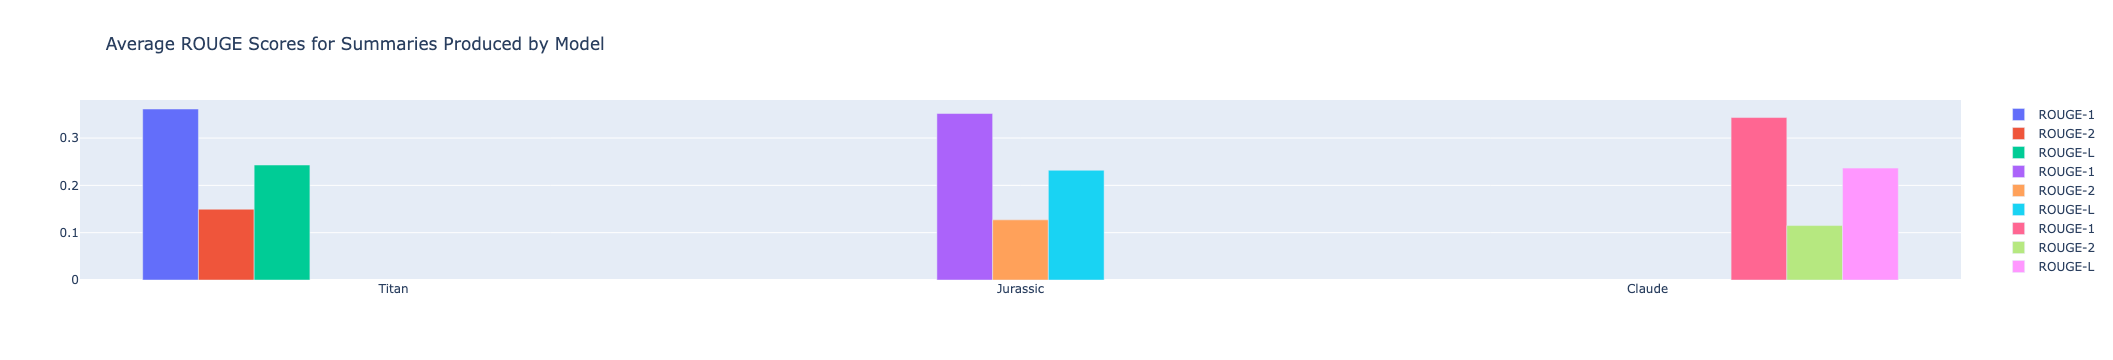

Calculating Cosine Similarities for summarization task ...


IntProgress(value=0, max=50)

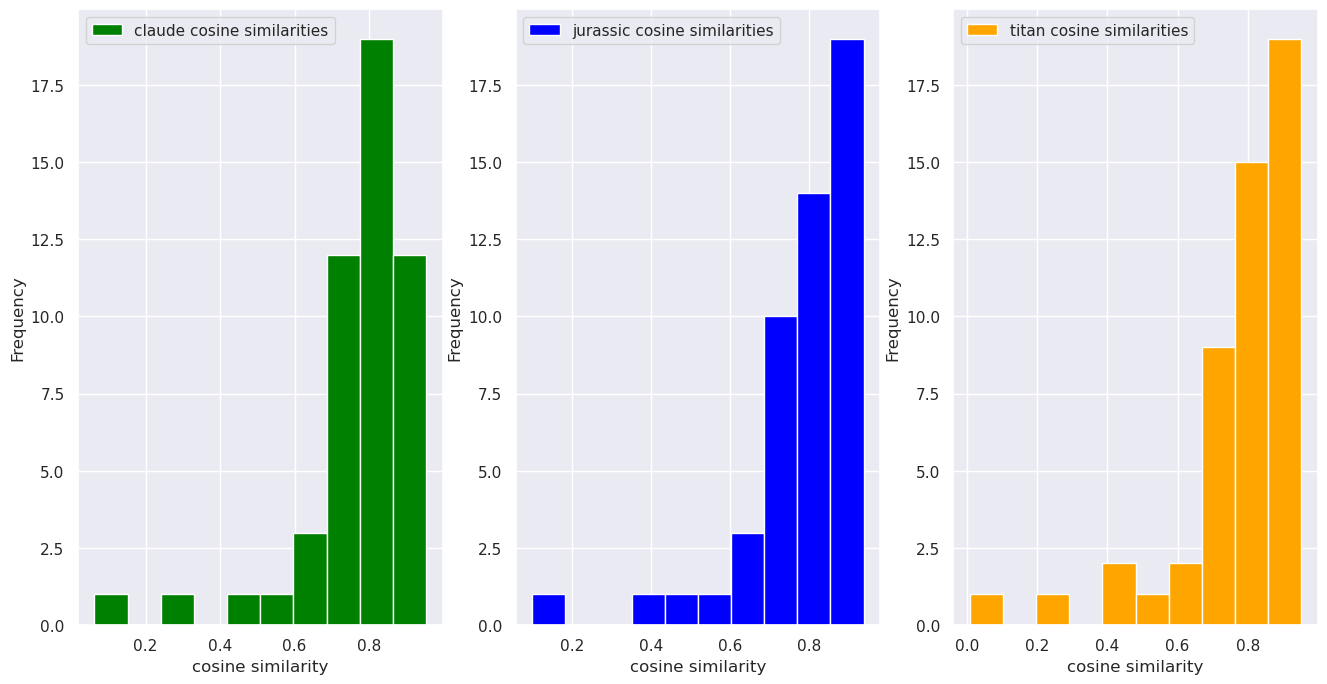

Claude-as-judge is evaluating summaries ...


IntProgress(value=0, max=50)

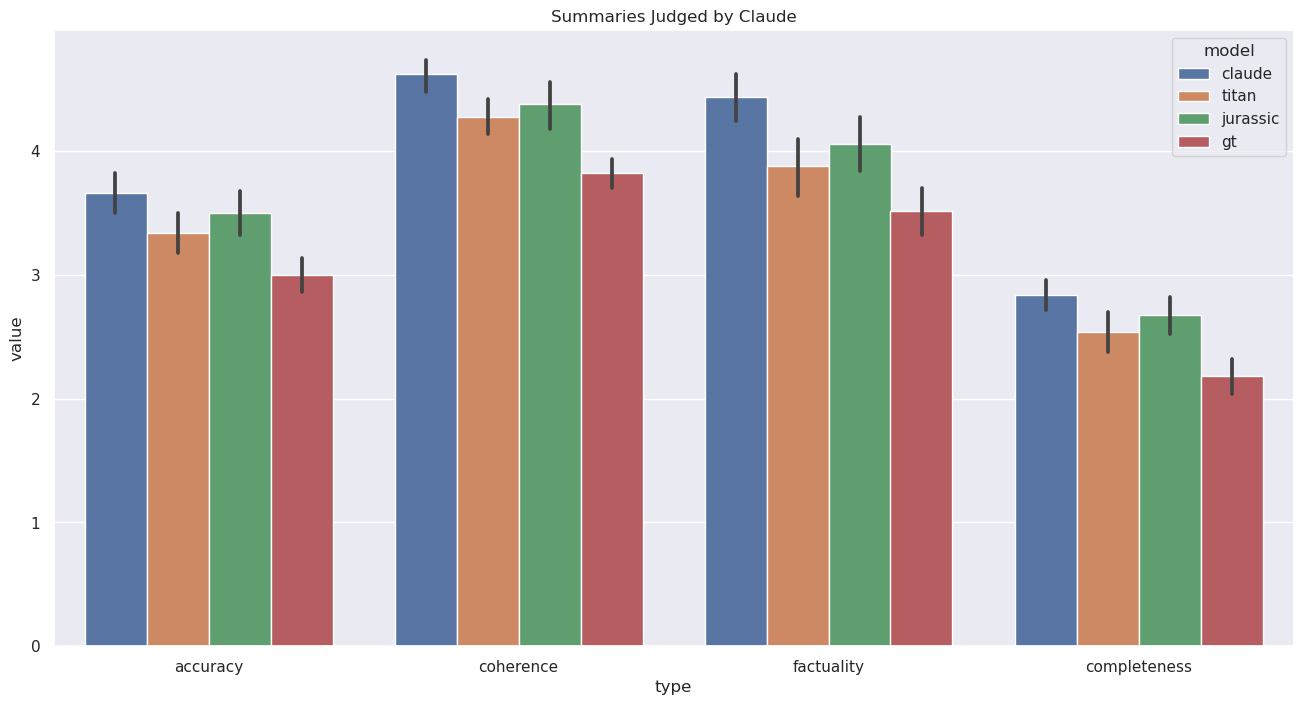

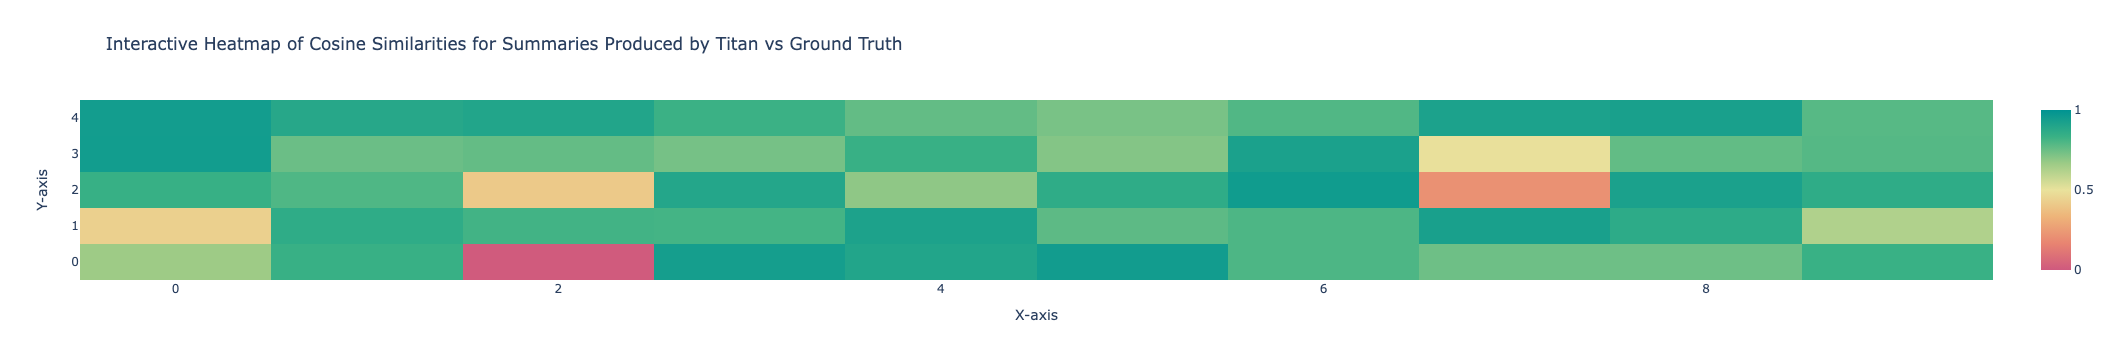

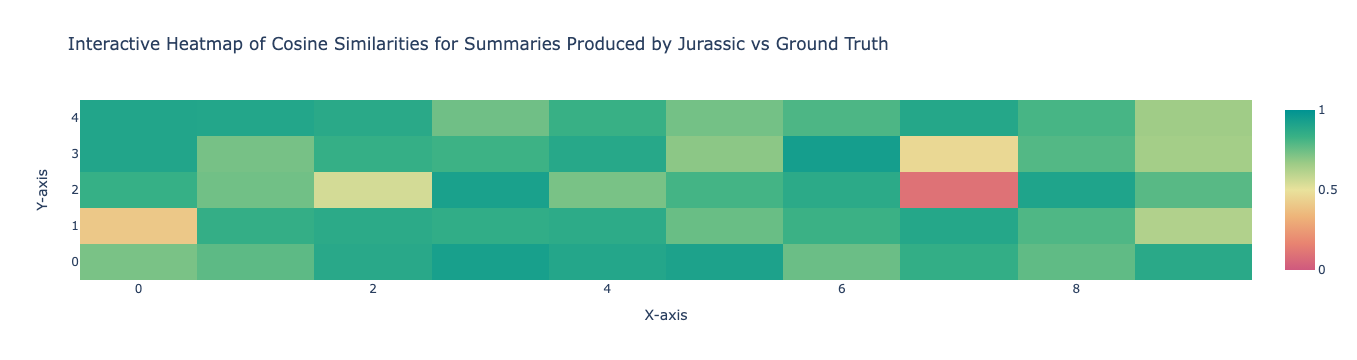

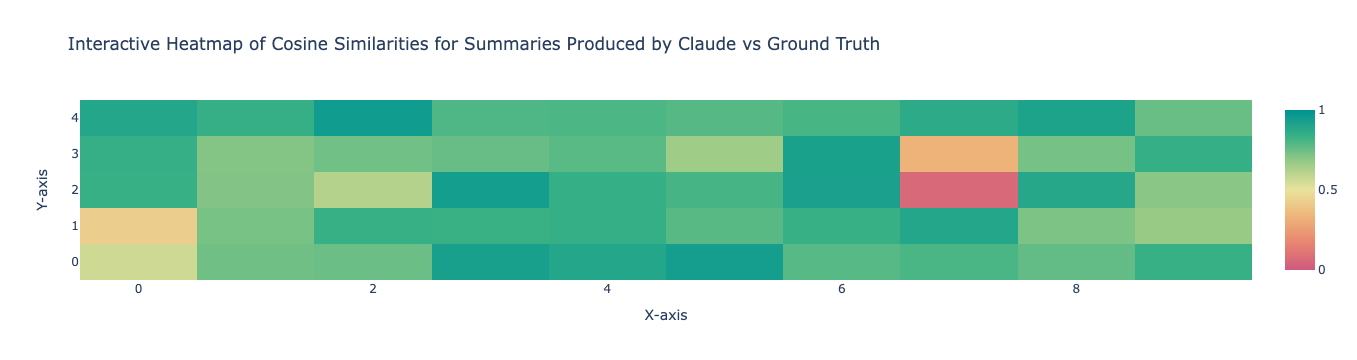

Chunking document and formulating questions for Q&A tasks ...


IntProgress(value=0, max=50)

Number of chunks added to vectordb & content store is: 50
Administering Multiple Choice Quiz ...


IntProgress(value=0, max=50)

Administering Reading Comprehension style Q&A test ...


IntProgress(value=0, max=50)

,Question,Titan's Answer,Jurassic's Answer,Claude's Answer,Correct Answer,Answer Choices
0,"What was Amazon's net sales in the second quarter of 2023?,",A,A,A,A,"[[A] Net sales increased 11% to $134.4 billion in the second quarter, compared with $121.2 billion in second quarter 2022.,, [B] Net sales increased 9% to $114.4 billion in the second quarter, compared with $121.2 billion in second quarter 2022. , [C] Net sales increased 10% to $124.4 billion in the second quarter, compared with $121.2 billion in second quarter 2022.,, [D] Net sales increased 15% to $144.4 billion in the second quarter, compared with $121.2 billion in second quarter 2022.,]"
1,"What was Amazon's net income in the second quarter of 2023?,",B,B,B,B,"[[A] Net income was $0.9 billion in the second quarter of 2023.,, [B] Net income was $6.7 billion in the second quarter, or $0.65 per diluted share, compared with a net loss of $2.0 billion,or $0.20 per diluted share, in second quarter 2022.,, [C] Net income was $5.4 billion in the second quarter of 2023.,, [D] Net income was $61.8 billion for the trailing twelve months ending in the second quarter of 2023. ]"
2,"What was Amazon's free cash flow less principal repayments of finance leases and financing obligations for the trailing twelve months ended June 30, 2022?,",D,D,C,C,"[[A] $23.5 billion for the trailing twelve months ended June 30, 2022, , [B] an outflow of $26.1 billion for the trailing twelve months ended June 30, 2022,, [C] $1.9 billion for the trailing twelve months, compared with an outflow of $33.5 billion for the trailing twelve months ended June 30, 2022.,, [D] an inflow of $6.7 billion for the trailing twelve months ended June 30, 2022 ]"
3,"What did Amazon release to make it easier and more cost-effective for companies to train and run models?,",B,B,B,B,"[[A] Amazon released advertising services to make it easier and more cost-effective for companies to train and run models. , [B] Amazon released Trainium and Inferentia chips to make it easier and more cost-effective for companies to train and run models.,, [C] Amazon released CodeWhisperer to make it easier and more cost-effective for companies to train and run models.,, [D] Amazon released Bedrock to make it easier and more cost-effective for companies to train and run models.,]"
4,"What was the biggest Prime Day event ever held by Amazon?,",A,A,A,A,"[[A] Held the biggest Prime Day event ever on July 11-12, in the third quarter, as Prime members worldwide purchased more than 375 million items and saved more than $2.5 billion.,, [B] The biggest Prime Day event was held in August 2020,, [C] The biggest Prime Day event was held in January 2020 , [D] The biggest Prime Day event was held in December 2019,]"
5,"What new brands did Amazon add to their U.S. store in 2022?,",C,C,C,C,"[[A] Amazon added new sporting goods brands including Nike, Adidas and Under Armour , [B] Amazon added new grocery brands including Coca-Cola and PepsiCo, , [C] Amazon added new beauty and fashion brands, including D’Amelio Footwear, Dyson hair care, IT Cosmetics, Ralph Lauren Fragrances, and Urban Decay,, [D] Amazon added new technology brands including Apple, Microsoft and Samsung,]"
6,"What program allows Amazon customers to save time and money on regularly scheduled deliveries?,",D,D,D,D,"[[A] Amazon Day deliveries give Prime members the ability to choose a designated day of the week for deliveries, , [B] Amazon Fresh offers grocery delivery within two hours for Prime members in select cities , [C] Amazon Business allows customers to procure products like office supplies and other bulk items easily and at discounted prices,, [D] Subscribe & Save, a program that helps customers save time and money on regularly scheduled deliveries. Customers select their preferred delivery frequency for eligible products and can cancel or change their subscription at any time.,]"
7,"What was the 10th anniversary Amazon India announced?,",D,D,D,D,"[[A] Amazon India did not announce 

,Question,Titan's Answer,Jurassic's Answer,Claude's Answer,Ground Truth
0,"What was Amazon's net sales in the second quarter of 2023?,",Amazon's net sales in the second quarter of 2023 were $134.4 billion.,Amazon's net sales in the second quarter of 2023 were $134.4 billion.,Amazon's net sales in the second quarter of 2023 were $134.4 billion.,"Net sales increased 11% to $134.4 billion in the second quarter, compared with $121.2 billion in second quarter 2022.,"
1,"What was Amazon's net income in the second quarter of 2023?,",Amazon's net income was $6.7 billion in the second quarter of 2023.,Net income was $6.7 billion in the second quarter of 2023.,Amazon's net income in the second quarter of 2023 was $6.7 billion.,"Net income was $6.7 billion in the second quarter, or $0.65 per diluted share, compared with a net loss of $2.0 billion,or $0.20 per diluted share, in second quarter 2022.,"
2,"What was Amazon's free cash flow less principal repayments of finance leases and financing obligations for the trailing twelve months ended June 30, 2022?,","Amazon's free cash flow less principal repayments of finance leases and financing obligations for the trailing twelve months ended June 30, 2022, was $1.9 billion.","Free cash flow less principal repayments of finance leases and financing obligations improved to an inflow of $1.9 billion for the trailing twelve months ended June 30, 2022.","Amazon's free cash flow less principal repayments of finance leases and financing obligations for the trailing twelve months ended June 30, 2022 was $1.9 billion.","$1.9 billion for the trailing twelve months, compared with an outflow of $33.5 billion for the trailing twelve months ended June 30, 2022.,"
3,"What did Amazon release to make it easier and more cost-effective for companies to train and run models?,",Amazon released Trainium and Inferentia chips.,Amazon released Trainium and Inferentia chips to make it easier and more cost-effective for companies to train and run models.,Amazon released Trainium and Inferentia chips to make it easier and more cost-effective for companies to train and run models.,"Amazon released Trainium and Inferentia chips to make it easier and more cost-effective for companies to train and run models.,"
4,"What was the biggest Prime Day event ever held by Amazon?,","Held the biggest Prime Day event ever on July 11-12, in the third quarter,",The biggest Prime Day event ever held by Amazon was in the third quarter of 2021.,"The biggest Prime Day event ever held by Amazon was on July 11-12, 2022.","Held the biggest Prime Day event ever on July 11-12, in the third quarter, as Prime members worldwide purchased more than 375 million items and saved more than $2.5 billion.,"
5,"What new brands did Amazon add to their U.S. store in 2022?,","Amazon added new beauty and fashion brands, including D’Amelio Footwear, Dyson hair care, IT Cosmetics, Ralph Lauren Fragrances, and Urban Decay,","Amazon added new beauty and fashion brands, including Dyson hair care, IT Cosmetics, Ralph Lauren Fragrances, and Urban Decay, to its U.S. store in 2022.","In 2022, Amazon added D’Amelio Footwear, Dyson hair care, IT Cosmetics, Ralph Lauren Fragrances, and Urban Decay to their U.S. store.","Amazon added new beauty and fashion brands, including D’Amelio Footwear, Dyson hair care, IT Cosmetics, Ralph Lauren Fragrances, and Urban Decay,"
6,"What program allows Amazon customers to save time and money on regularly scheduled deliveries?,","Subscribe & Save, a program that helps customers save time and money on regularly scheduled deliveries.","Subscribe & Save, a program that helps customers save time and money on regularly scheduled deliveries.",Subscribe & Save allows Amazon customers to save time and money on regularly scheduled deliveries.,"Subscribe & Save, a program that helps customers save time and money on regularly scheduled deliveries. Customers select their preferred delivery frequency for eligible products and can cancel or change their

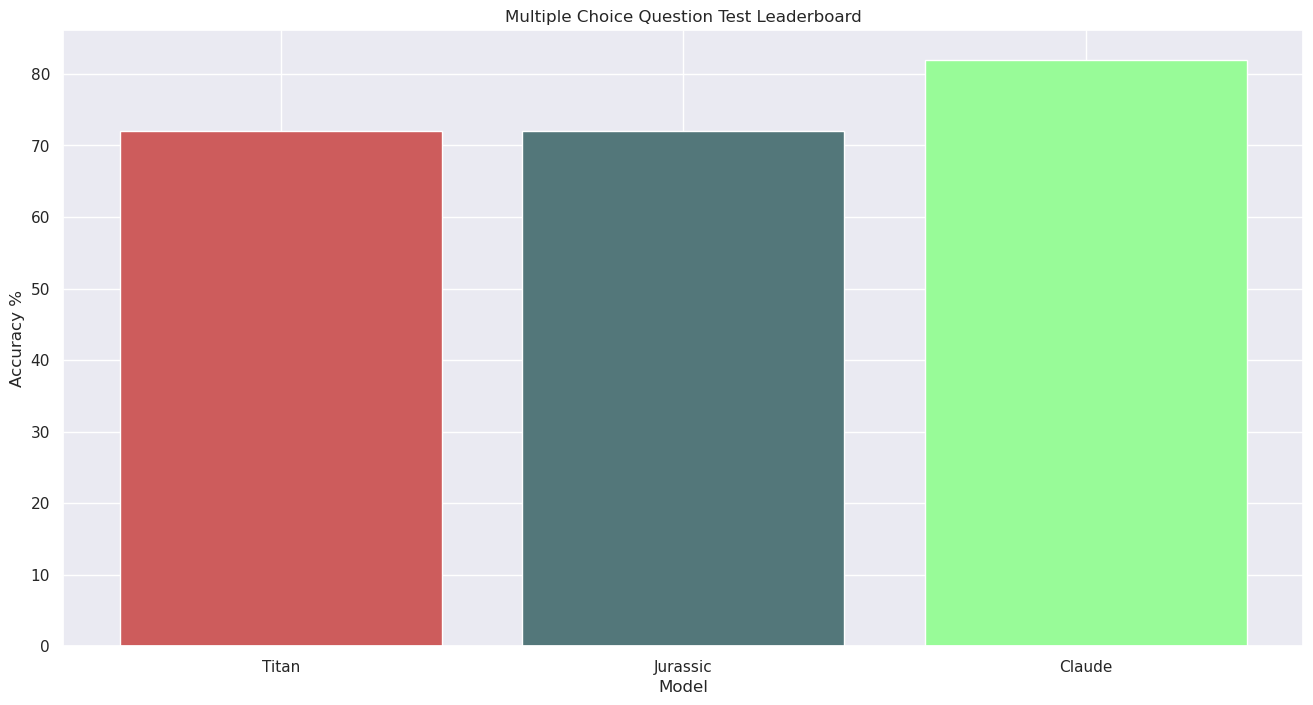

Number of Multiple Choice Questions Asked: 50
Titan's Score on multiple choice test is 36 and accuracy is 72.0
Jurassic's Score on multiple choice test is 36 and accuracy is 72.0
Claude's Score on multiple choice test is 41 and accuracy is 82.0



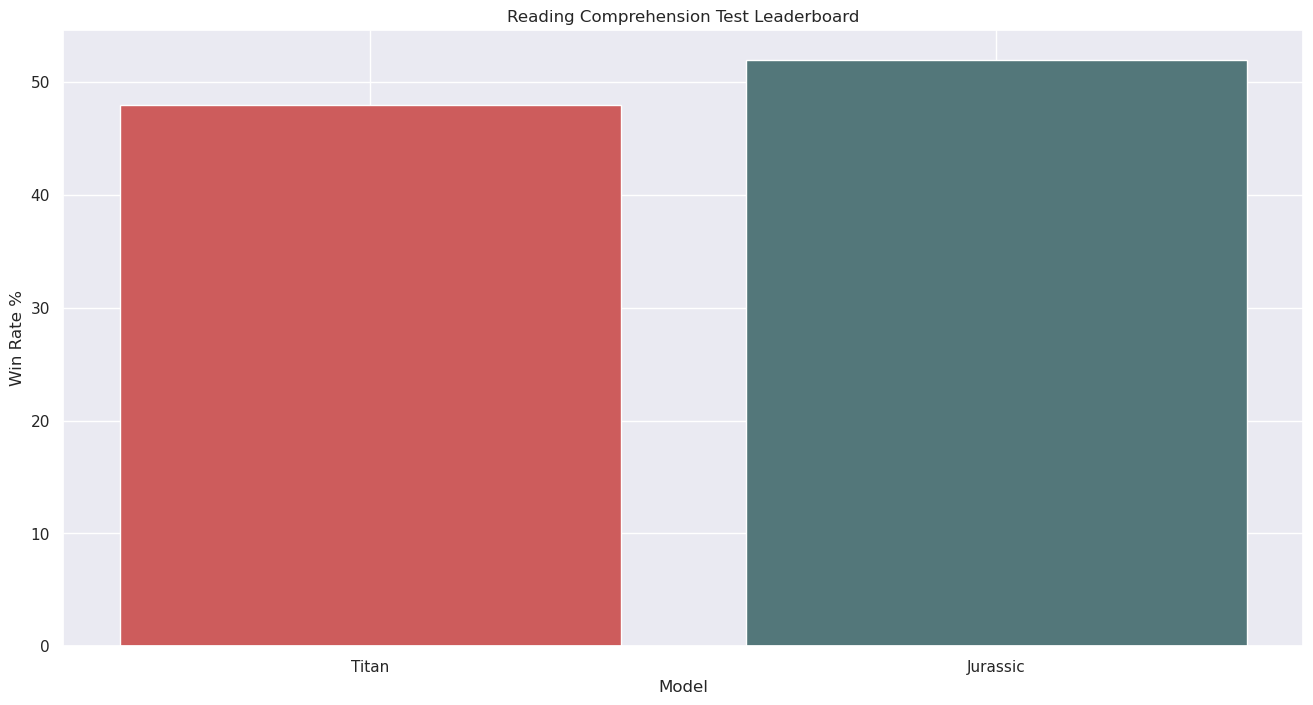

No. of Reading Comprehension style questions asked: 50
No. of times Titan scored better than other models in reading comprehension test is 24 and win rate is 48.0
No. of times Jurassic's scored better than other models on reading comprehension test is 26 and win rate is 52.0


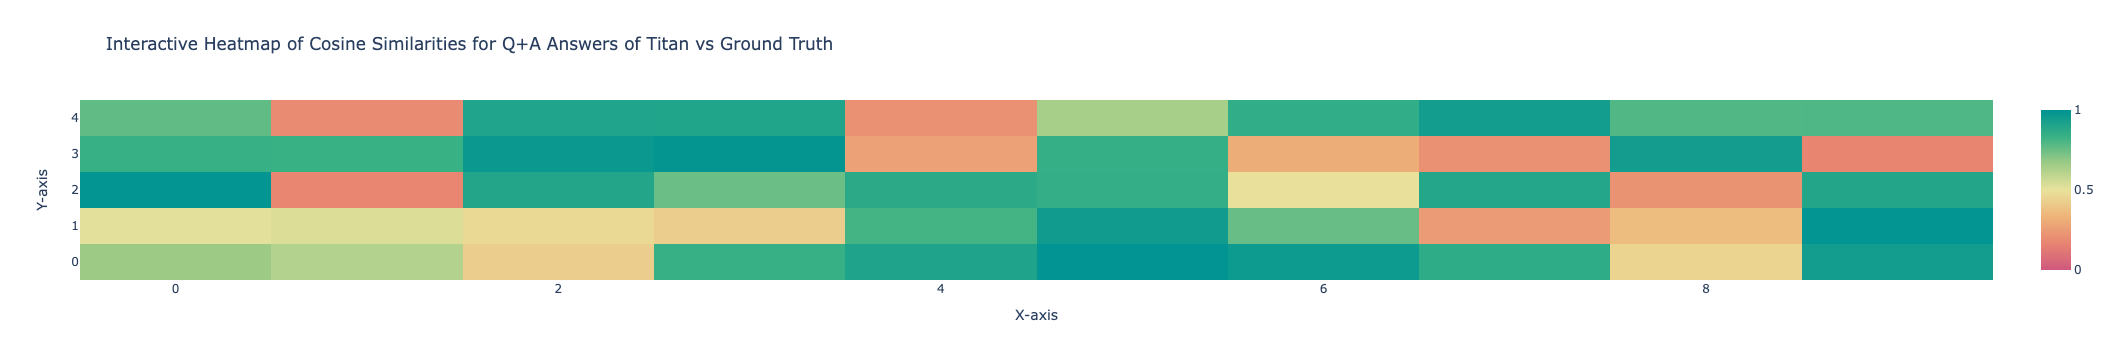

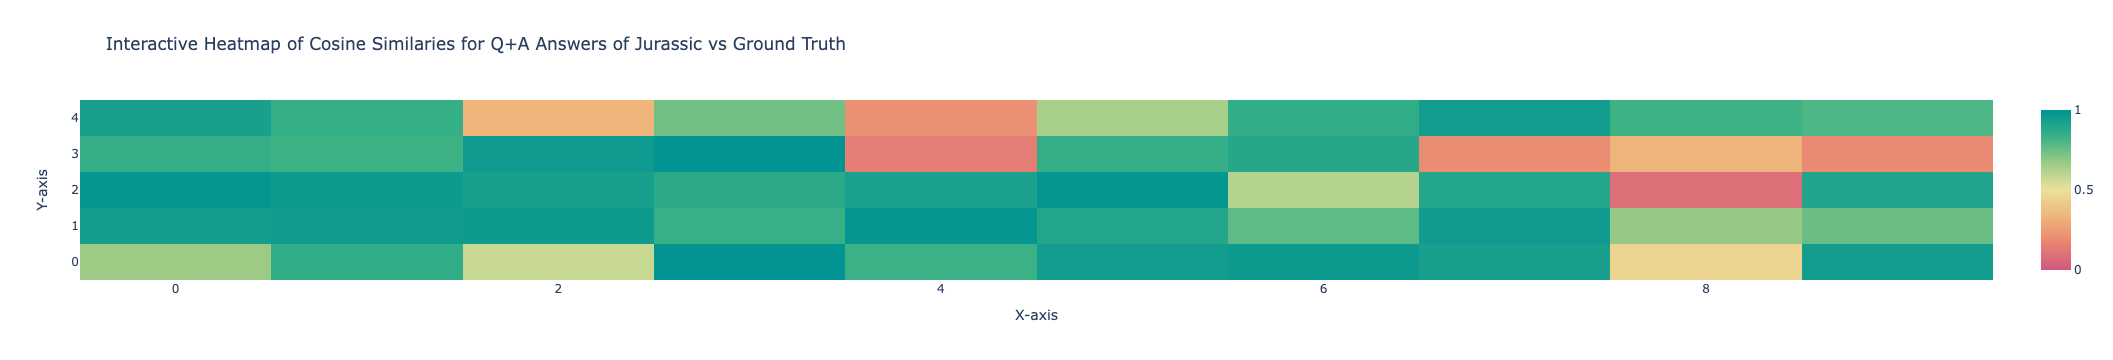

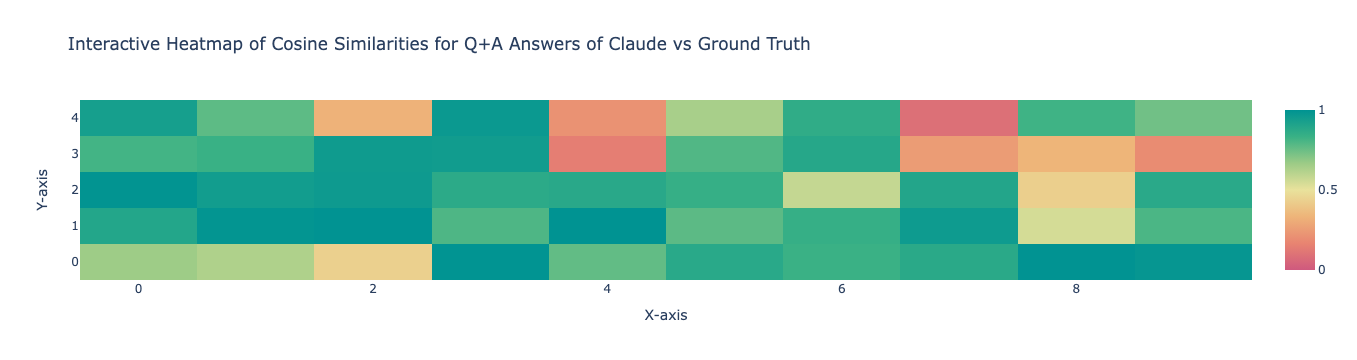

In [68]:
#
# Location of input file for Reading Comprehension & Multiple Choice Q+A tests
# We automatically create questions from this document and administer the tests
#
# files="data/amazon10k.pdf"
# files="data/hawaii.txt"
# files="data/Q1-2023-Amazon-Earnings-Release.pdf"
files = "data/Q2-2023-Amazon-Earnings-Release.pdf"


#
# Tuneable sleep timers between consecutive calls to model endpoints to avoid endpoint Throttling Errors
#
titan_sleep_timer = 0
jurassic_sleep_timer = 0
claude_sleep_timer = 0
oneshot_sleep_timer = 0


#
# User tuneable number of documents to evaluation for Summarization Task. We source these documents from CNN/Daily Mail Summmarization Dataset as of now
#
num_to_eval = 50

#
# User tuneable umber of questions to ask in Multiple Choice and in Reading Comprehension Tests
#
num_questions = 50


if __name__ == "__main__":
    main()